In [5]:
import numpy as np
import pandas as pd
import pandas_profiling
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE

import eda
import importlib
import psutil

In [6]:
print('total =', psutil.virtual_memory().total/(1024**3))
print('used =', psutil.virtual_memory().used/(1024**3))
print('available =', psutil.virtual_memory().available/(1024**3))
print('free =', psutil.virtual_memory().free/(1024**3))
print('percent =', psutil.virtual_memory().percent)

total = 7.753620147705078
used = 6.5999298095703125
available = 1.1536903381347656
free = 1.1536903381347656
percent = 85.1


read data

In [7]:
df = pd.read_csv('baf/Variant III.csv')
df.shape

(1000000, 34)

In [8]:
class_col = 'fraud_bool'
month_col = 'month'
one_value_cols = [col for col in df.columns if df[col].nunique() <= 1]
feat_cols = [c for c in df.columns if c != class_col and c != month_col and c not in one_value_cols]

num_cols = df[feat_cols].select_dtypes(include='number').columns.tolist()
str_cols = [x for x in feat_cols if x not in num_cols]

print(len(df.columns))
print(len(feat_cols))
print(len(num_cols))
print(len(str_cols))

34
31
26
5


eda

In [94]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
fraud_bool,1000000.0,NaN,NaN,NaN,0.01103,0.104443,0.0,0.0,0.0,0.0,1.0
income,1000000.0,NaN,NaN,NaN,0.578781,0.288256,0.1,0.3,0.6,0.8,0.9
name_email_similarity,1000000.0,NaN,NaN,NaN,0.487591,0.29149,0.0,0.214502,0.485869,0.754487,1.0
prev_address_months_count,1000000.0,NaN,NaN,NaN,14.673201,43.021896,-1.0,-1.0,-1.0,-1.0,399.0
current_address_months_count,1000000.0,NaN,NaN,NaN,99.23193,94.074799,-1.0,27.0,64.0,154.0,429.0
customer_age,1000000.0,NaN,NaN,NaN,41.34466,13.766883,10.0,30.0,50.0,50.0,90.0
days_since_request,1000000.0,NaN,NaN,NaN,0.904785,5.011008,0.0,0.007447,0.015672,0.026917,76.577505
intended_balcon_amount,1000000.0,NaN,NaN,NaN,8.54686,20.52208,-15.739893,-1.179975,-0.834825,-0.071338,112.702504
payment_type,1000000,5,AB,399268,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zip_count_4w,1000000.0,NaN,NaN,NaN,1517.657134,965.034144,1.0,886.0,1208.0,1844.0,6650.0


Some problems:
- customer_age 10 tuổi?
- days_since_request giá trị lẻ?
- intended_balcon_amount: vì sao nhiều giá trị negative khác nhau?
- payment_type, employment_status, housing_status annonymized
- velocity_6h giá trị âm?

In [96]:
df['fraud_bool'].value_counts()

0    988970
1     11030
Name: fraud_bool, dtype: int64

In [7]:
report = pandas_profiling.ProfileReport(df)
report.to_file('report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [97]:
df.isnull().sum().sort_values(ascending=False)

fraud_bool                          0
source                              0
phone_home_valid                    0
phone_mobile_valid                  0
bank_months_count                   0
has_other_cards                     0
proposed_credit_limit               0
foreign_request                     0
session_length_in_minutes           0
income                              0
device_os                           0
keep_alive_session                  0
device_distinct_emails_8w           0
device_fraud_count                  0
month                               0
x1                                  0
housing_status                      0
email_is_free                       0
credit_risk_score                   0
employment_status                   0
date_of_birth_distinct_emails_4w    0
bank_branch_count_8w                0
velocity_4w                         0
velocity_24h                        0
velocity_6h                         0
zip_count_4w                        0
payment_type

corr

In [9]:
df.corr()[class_col].sort_values(ascending=False)

C:\Users\h\AppData\Local\Temp\ipykernel_26220\853545949.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()[class_col].sort_values(ascending=False)


fraud_bool                          1.000000
x2                                  0.119711
x1                                  0.119569
proposed_credit_limit               0.068140
credit_risk_score                   0.068089
income                              0.040996
device_distinct_emails_8w           0.029622
email_is_free                       0.028088
current_address_months_count        0.023340
customer_age                        0.018492
foreign_request                     0.016149
zip_count_4w                        0.010140
session_length_in_minutes           0.006141
days_since_request                  0.002938
month                               0.002770
velocity_4w                        -0.002217
velocity_24h                       -0.004875
bank_months_count                  -0.006096
phone_mobile_valid                 -0.008129
velocity_6h                        -0.013662
bank_branch_count_8w               -0.013858
date_of_birth_distinct_emails_4w   -0.019357
prev_addre

In [10]:
corr_cols = df.corr()[class_col].sort_values(ascending=False).index.tolist()
num_cols_sorted = [c for c in corr_cols if c in num_cols]
feat_cols_sorted = [c for c in corr_cols if c in feat_cols]

corr_cols_2 = df.corr()[class_col].abs().sort_values(ascending=False).index.tolist()
feat_cols_sorted_2 = [c for c in corr_cols_2 if c in feat_cols]

C:\Users\h\AppData\Local\Temp\ipykernel_26220\7455091.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_cols = df.corr()[class_col].sort_values(ascending=False).index.tolist()
C:\Users\h\AppData\Local\Temp\ipykernel_26220\7455091.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_cols_2 = df.corr()[class_col].abs().sort_values(ascending=False).index.tolist()


plot

d:\jupyter\banking\eda.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=y, x=feat_col, hue=class_col, common_norm=False, ax=axs[i,j])


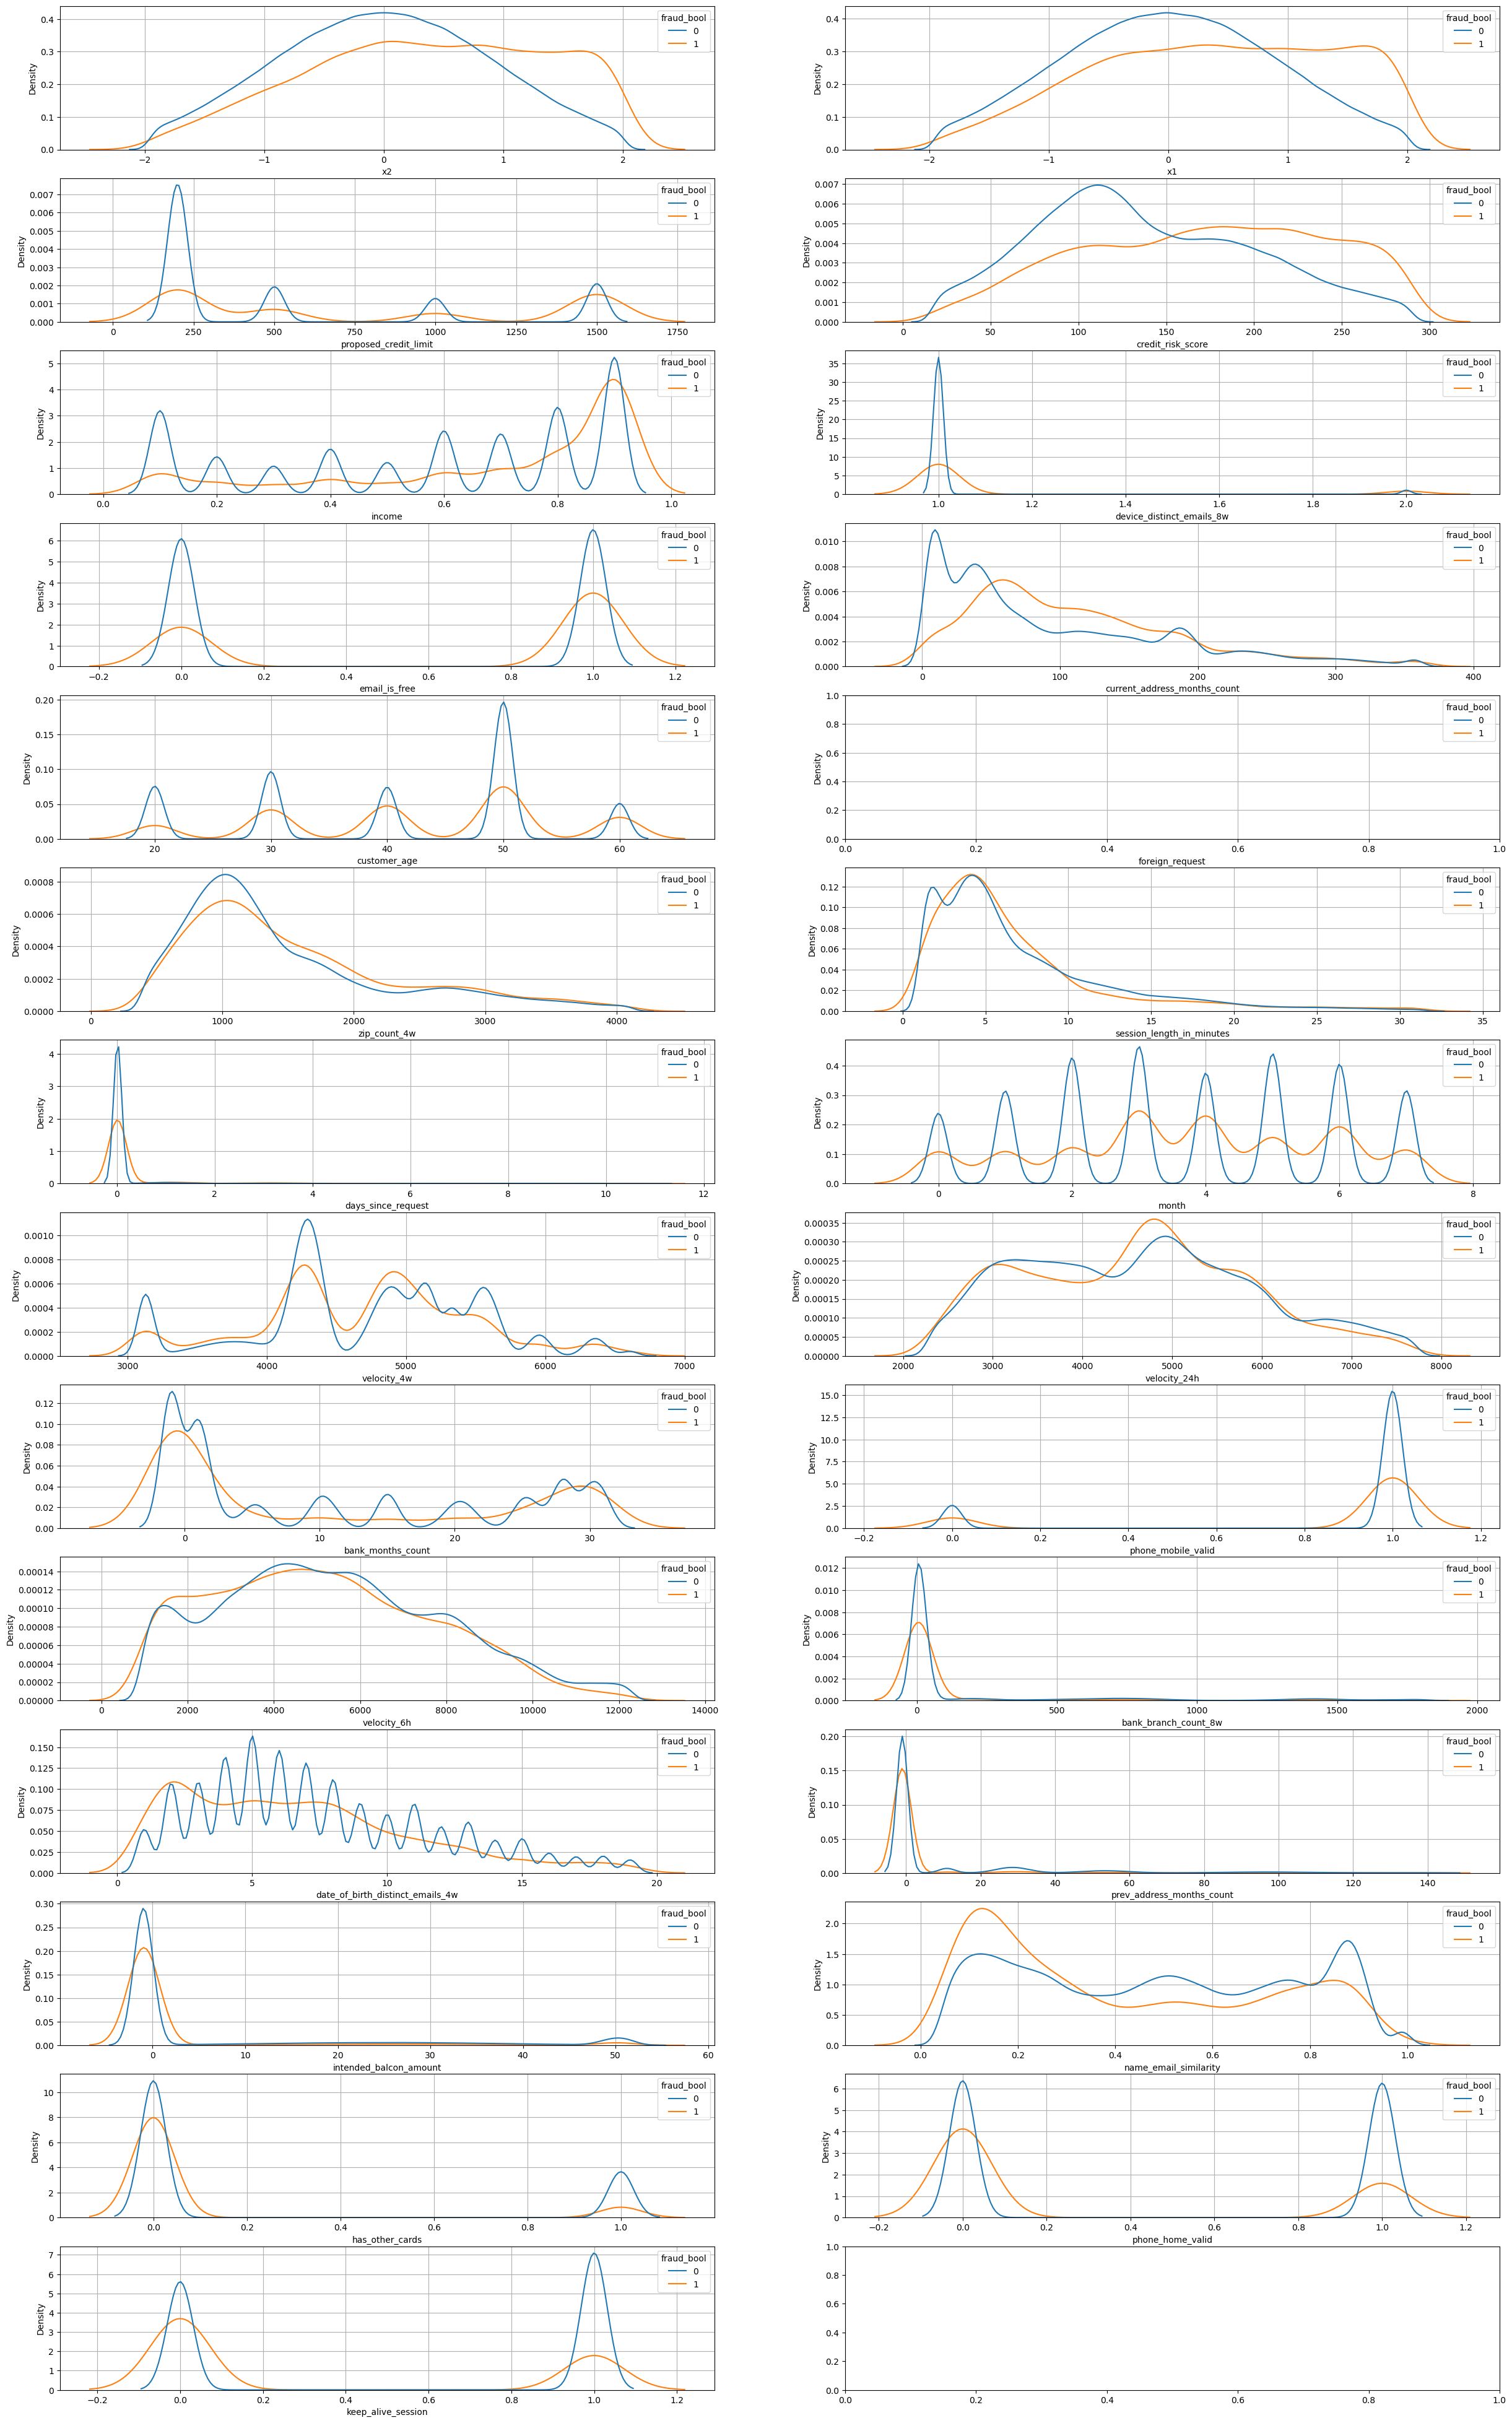

In [36]:
eda.EDAPlot().plot_dist_by_class(df=df, feat_cols=num_cols_sorted, class_col=class_col, ncols=2, kind='kde')

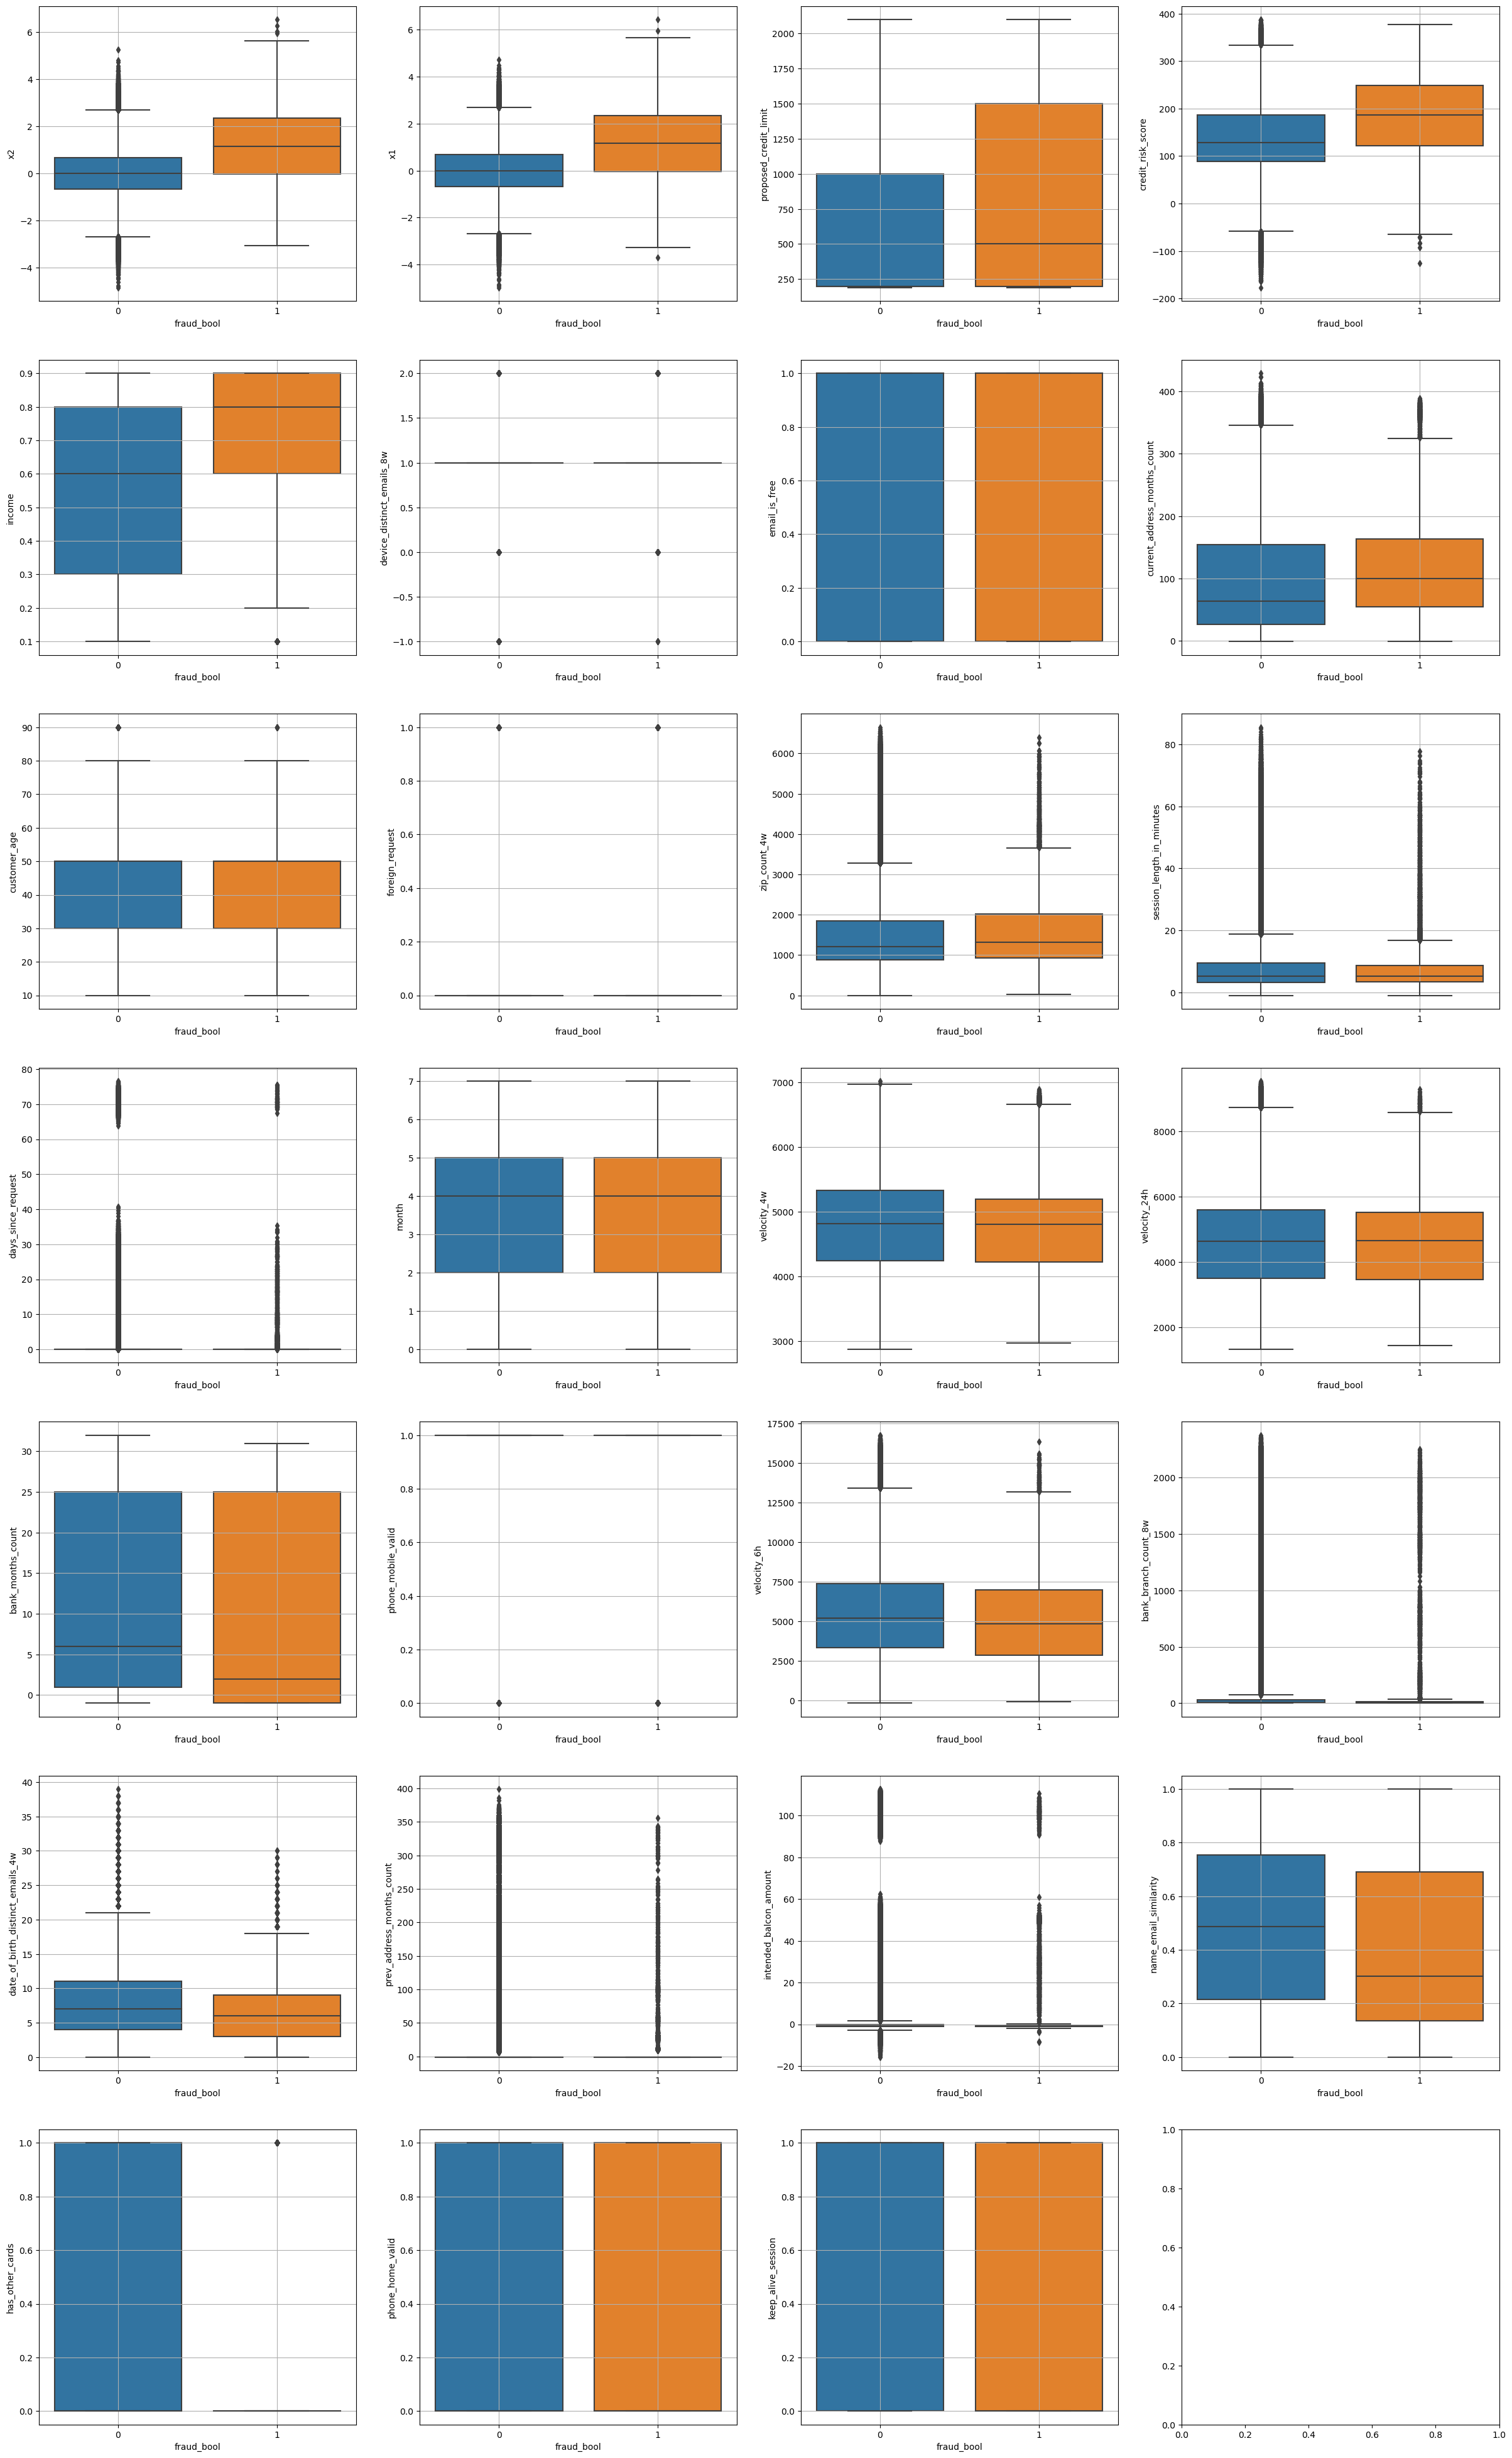

In [37]:
eda.EDAPlot().plot_dist_by_class(df=df, feat_cols=num_cols_sorted, class_col=class_col, ncols=4, kind='boxplot')

d:\jupyter\banking\eda.py:44: RuntimeWarning: divide by zero encountered in log
  z = np.power(10.0, np.floor(np.log(x)/np.log(10)))
d:\jupyter\banking\eda.py:46: RuntimeWarning: invalid value encountered in double_scalars
  x_rounded = x//z*z
c:\Users\h\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\h\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\jupyter\banking\eda.py:231: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,2,figsize=(w,h))


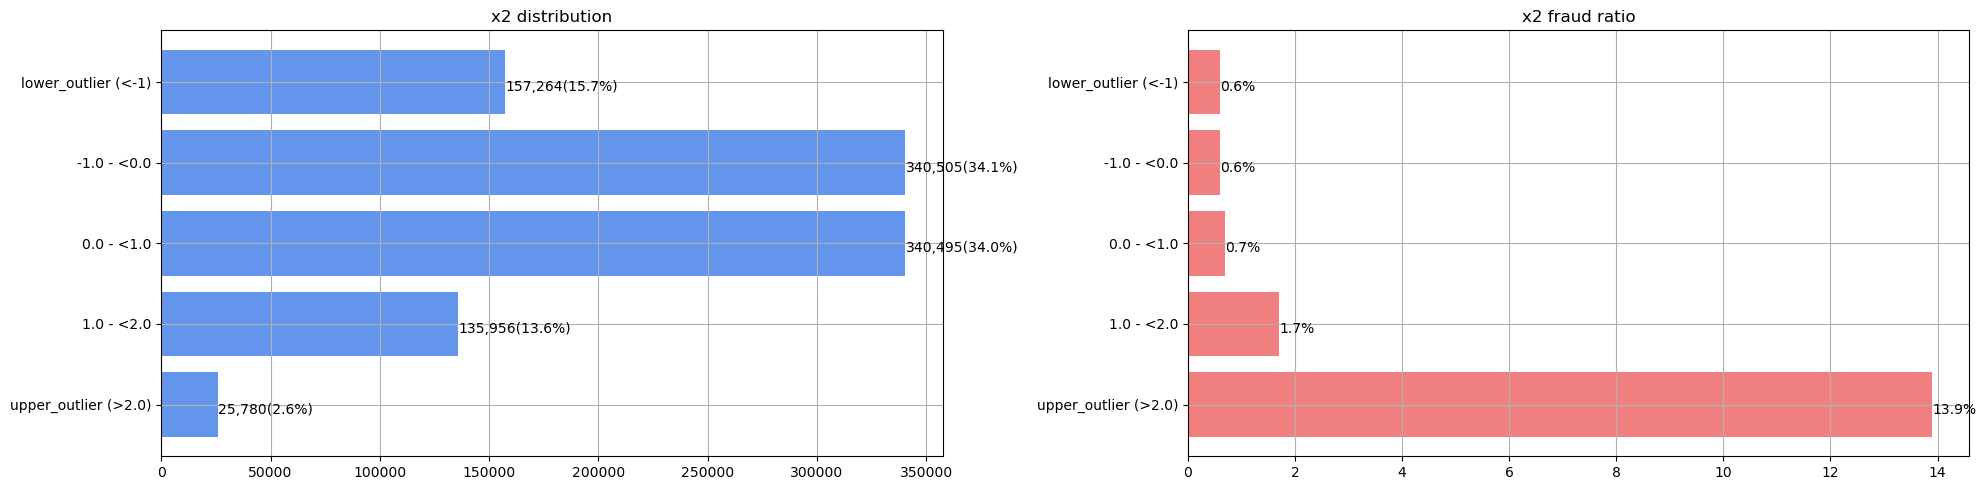

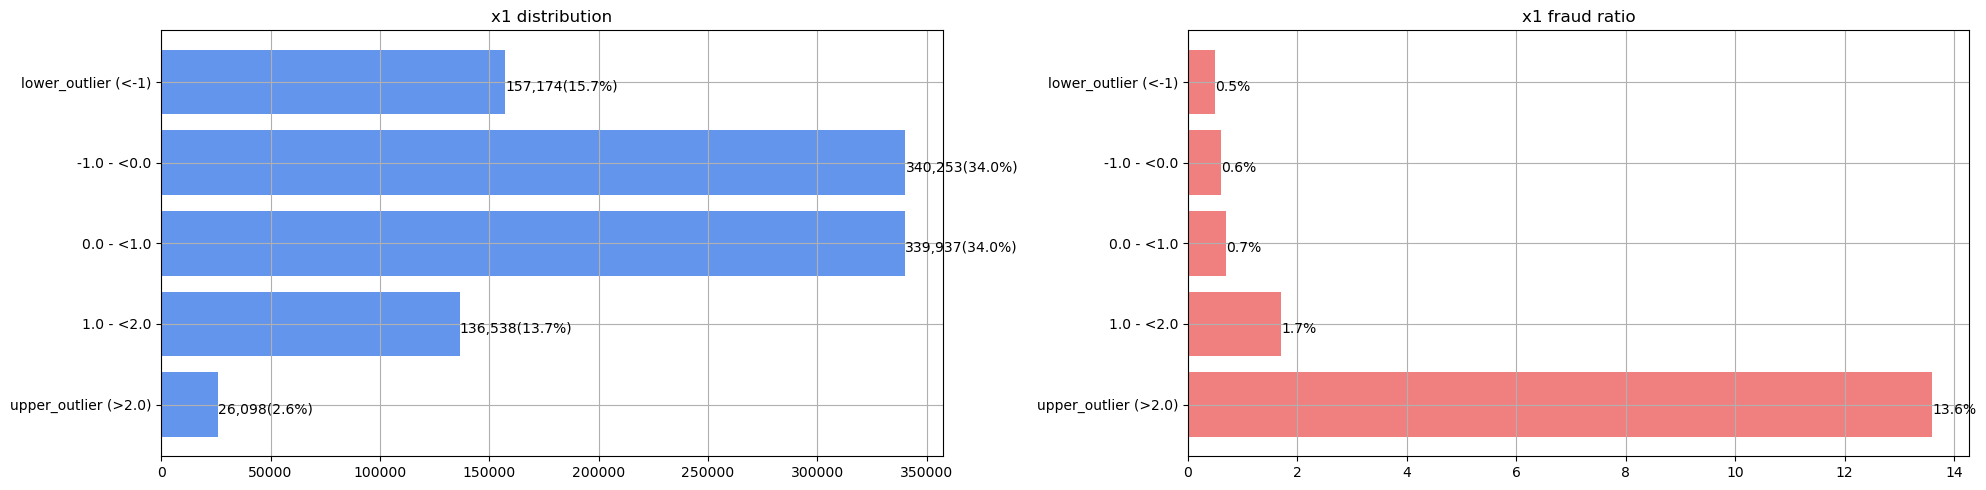

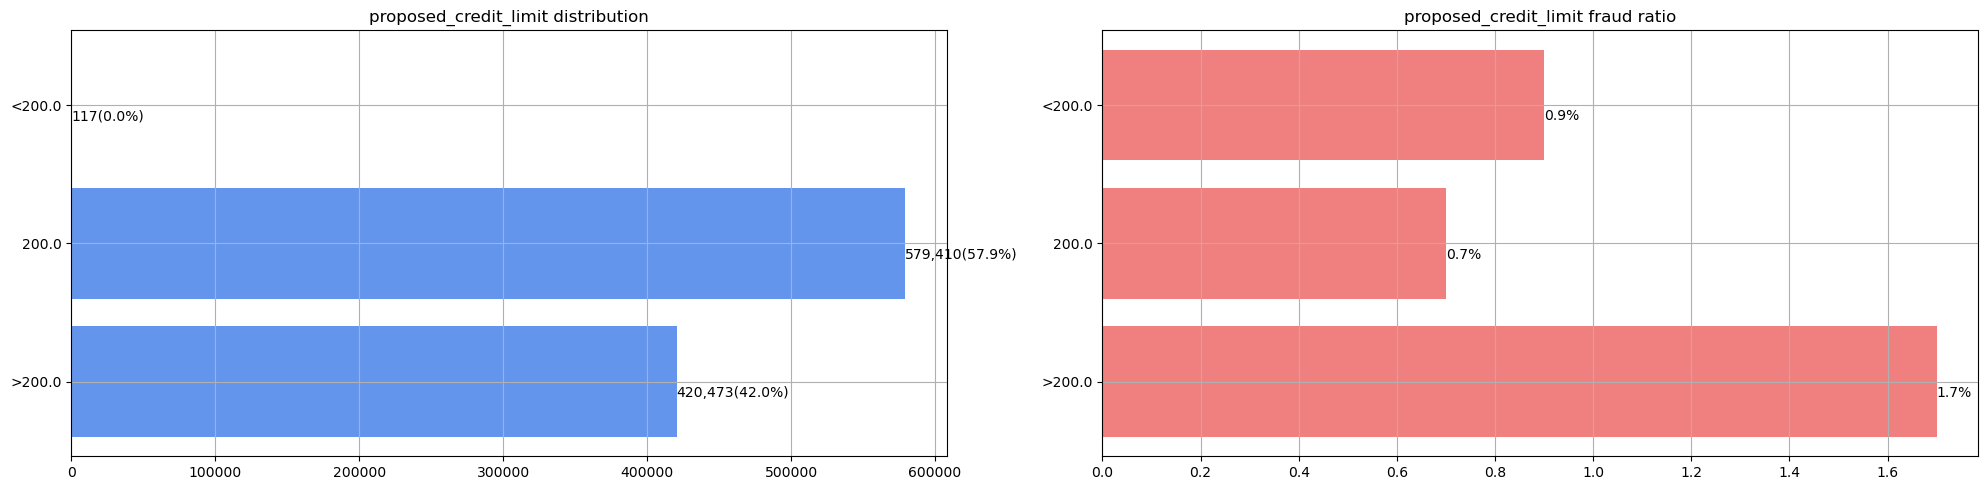

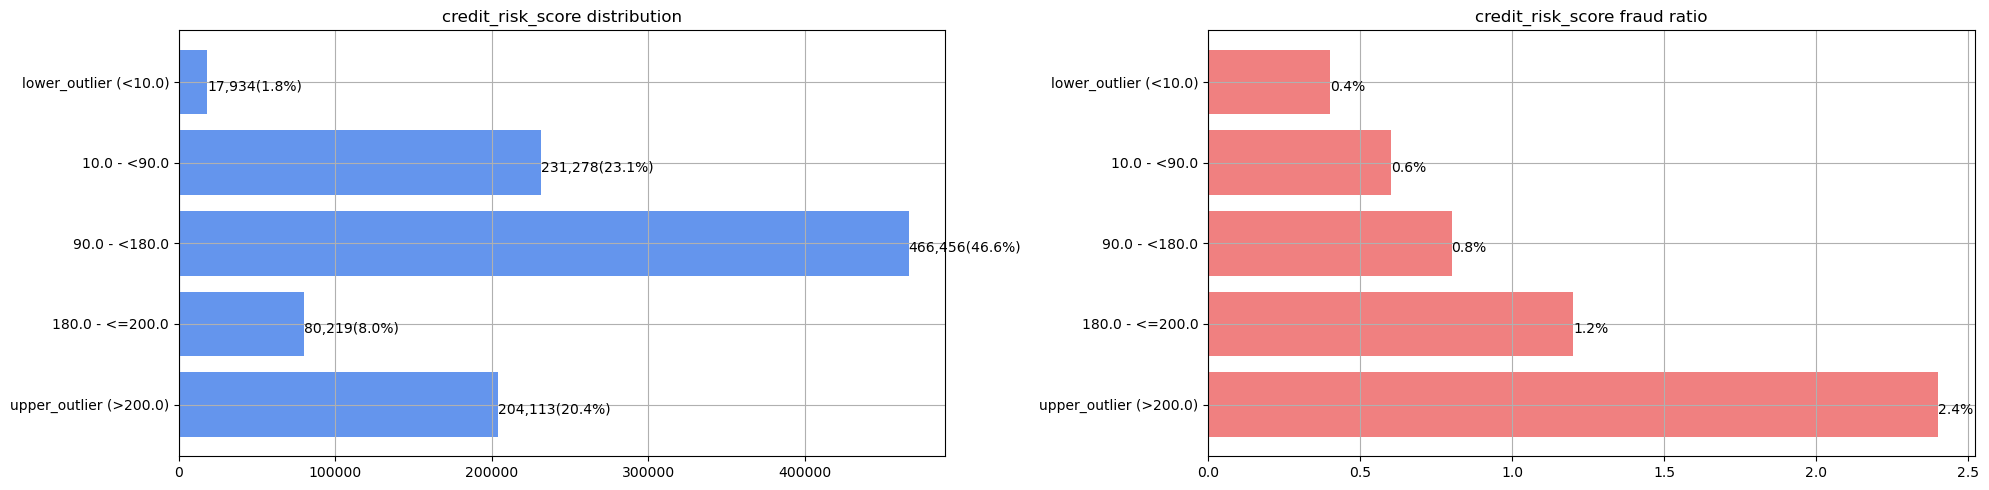

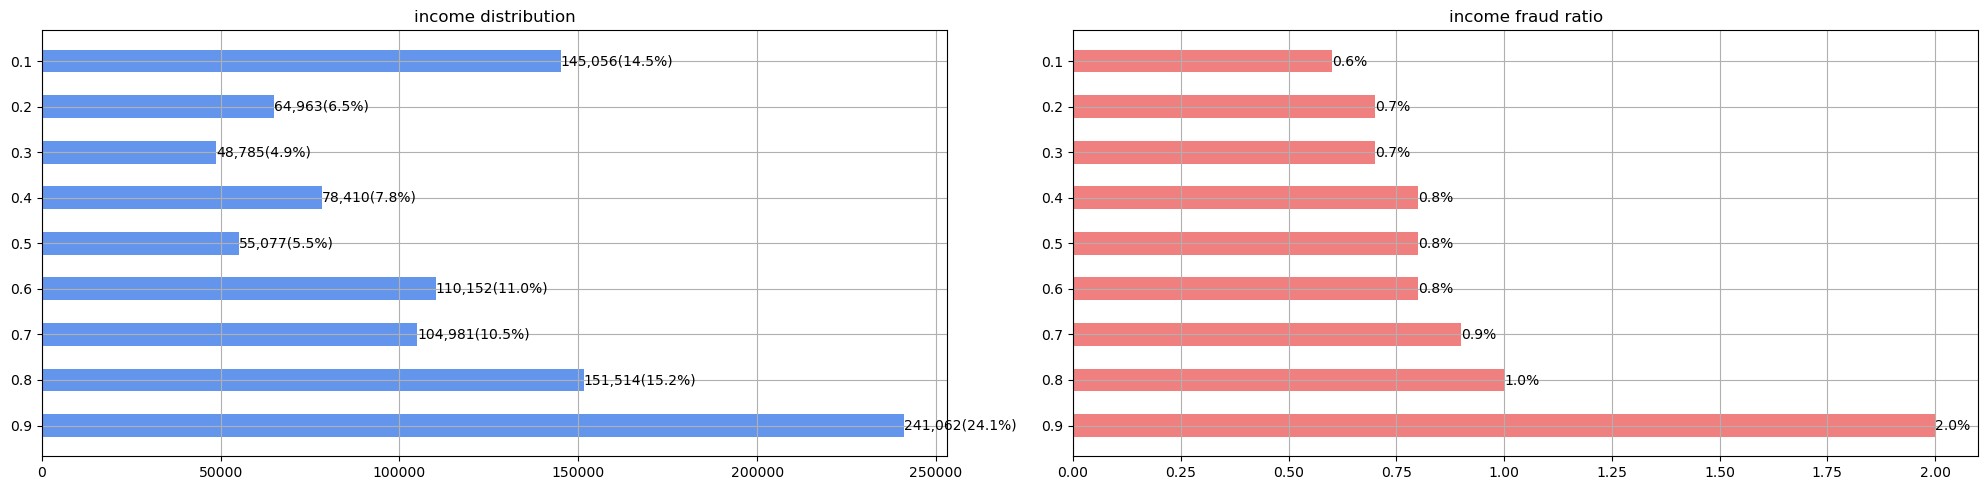

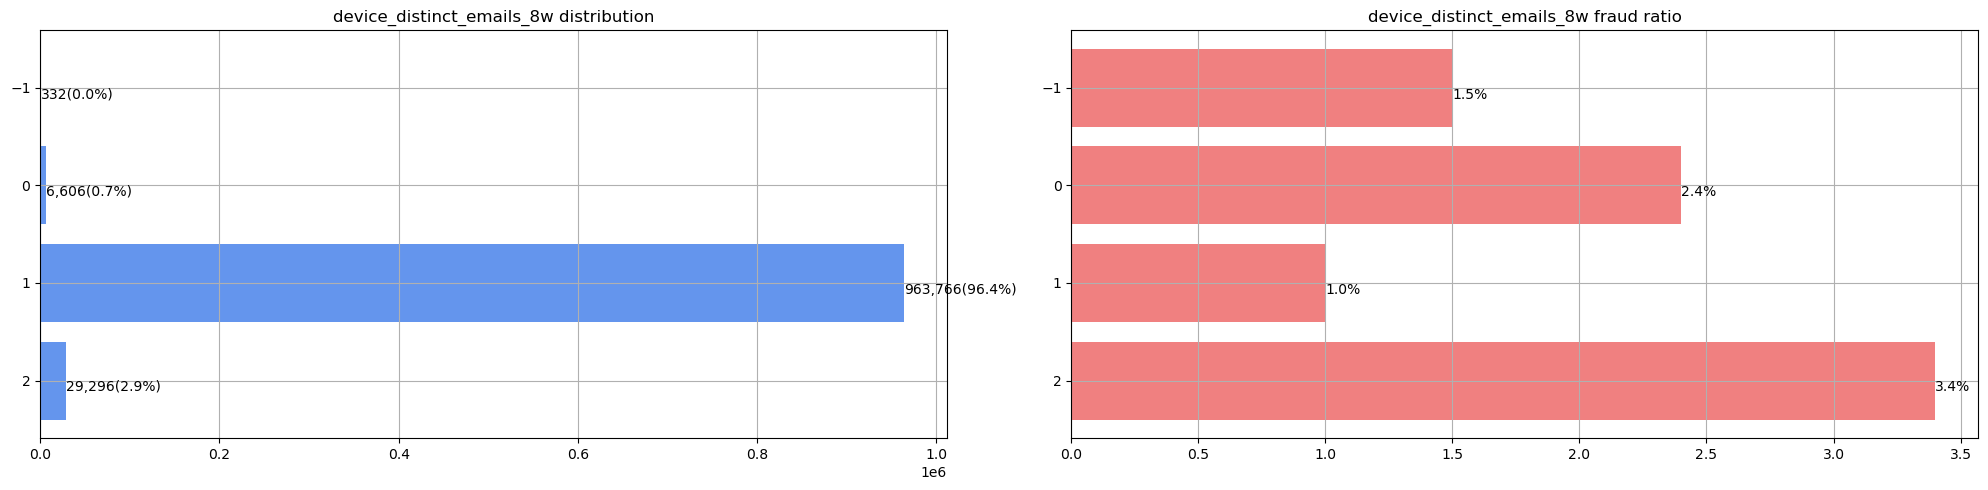

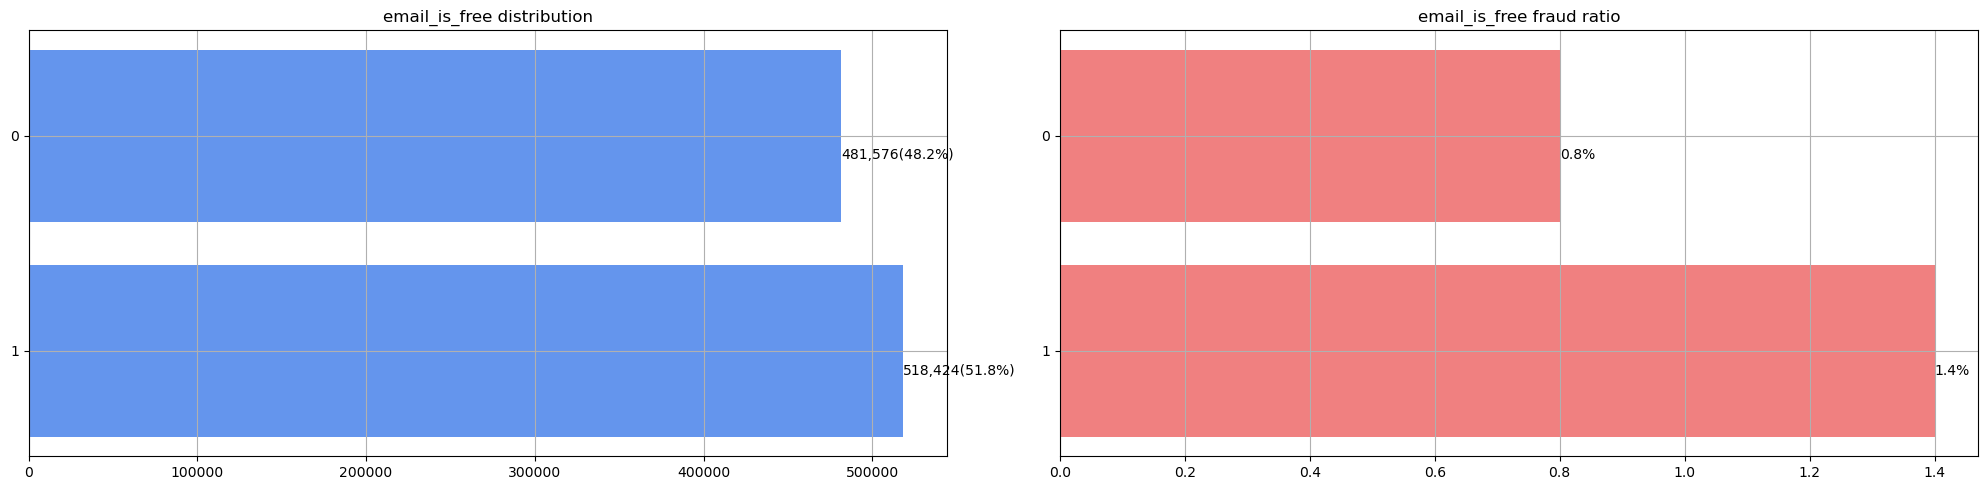

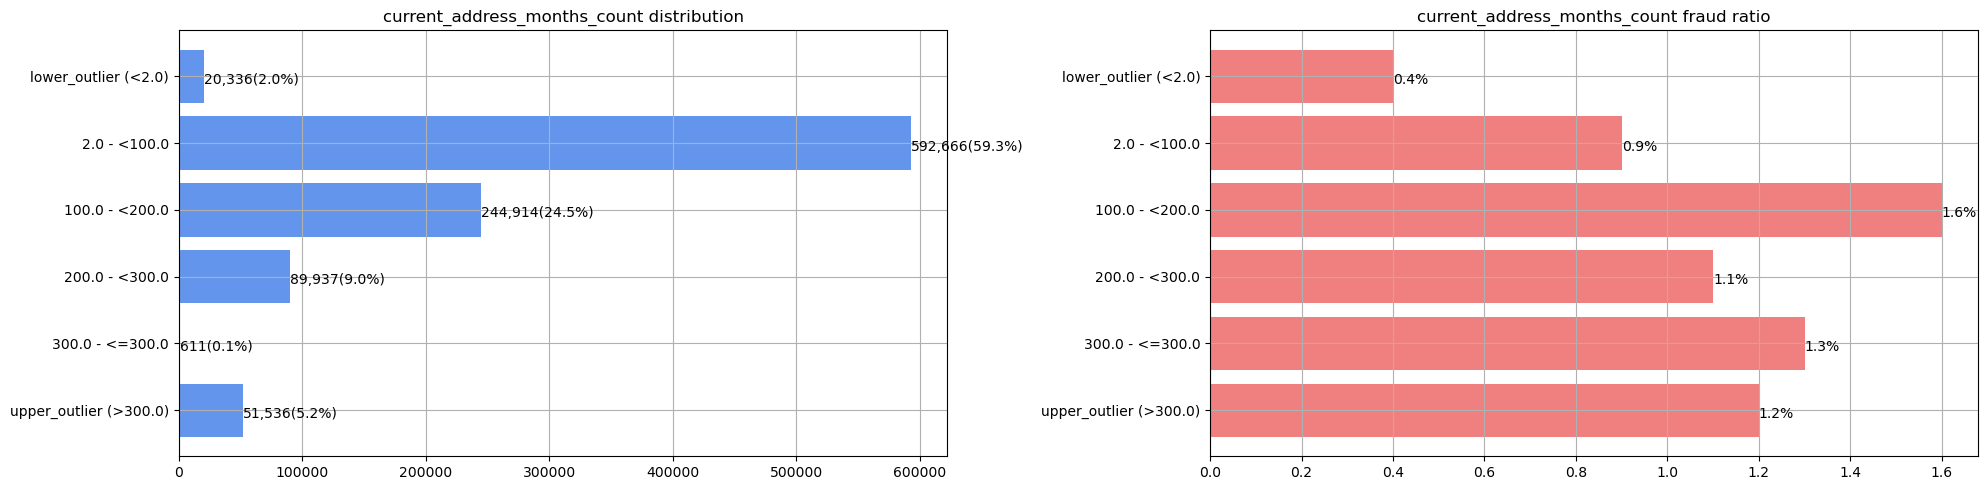

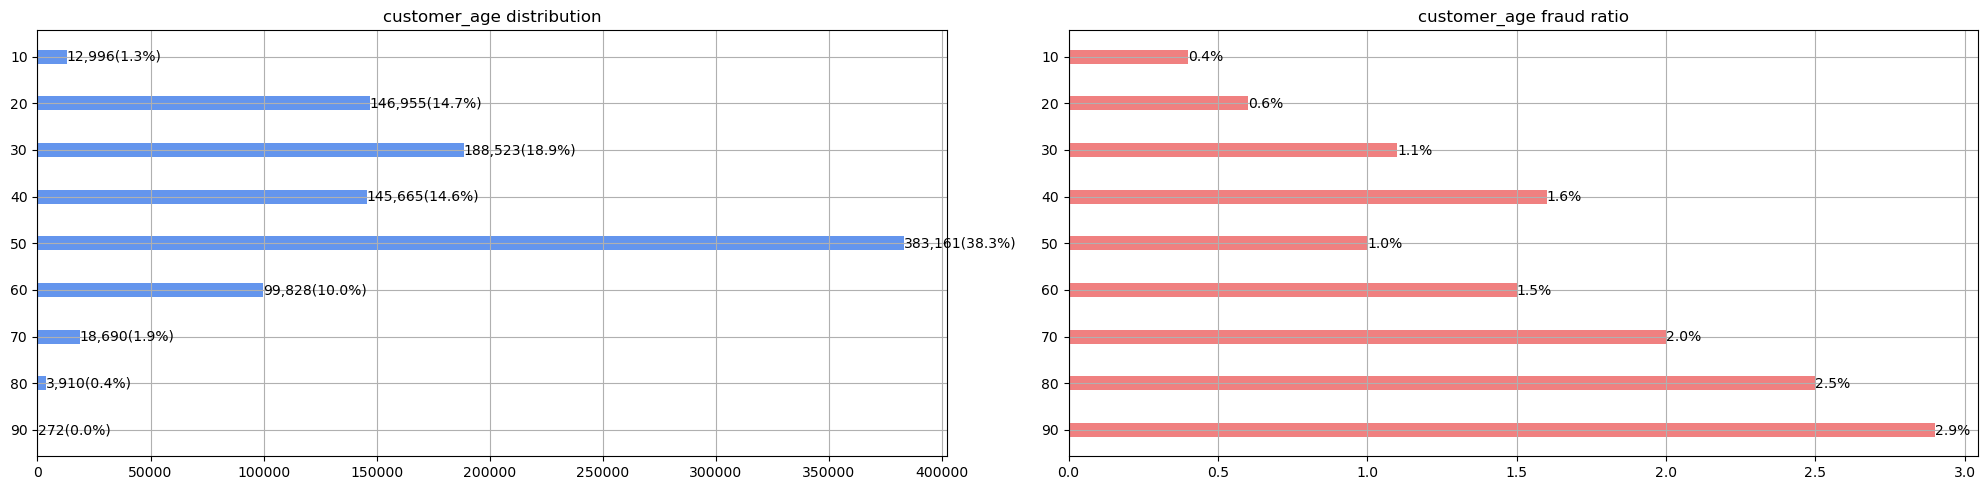

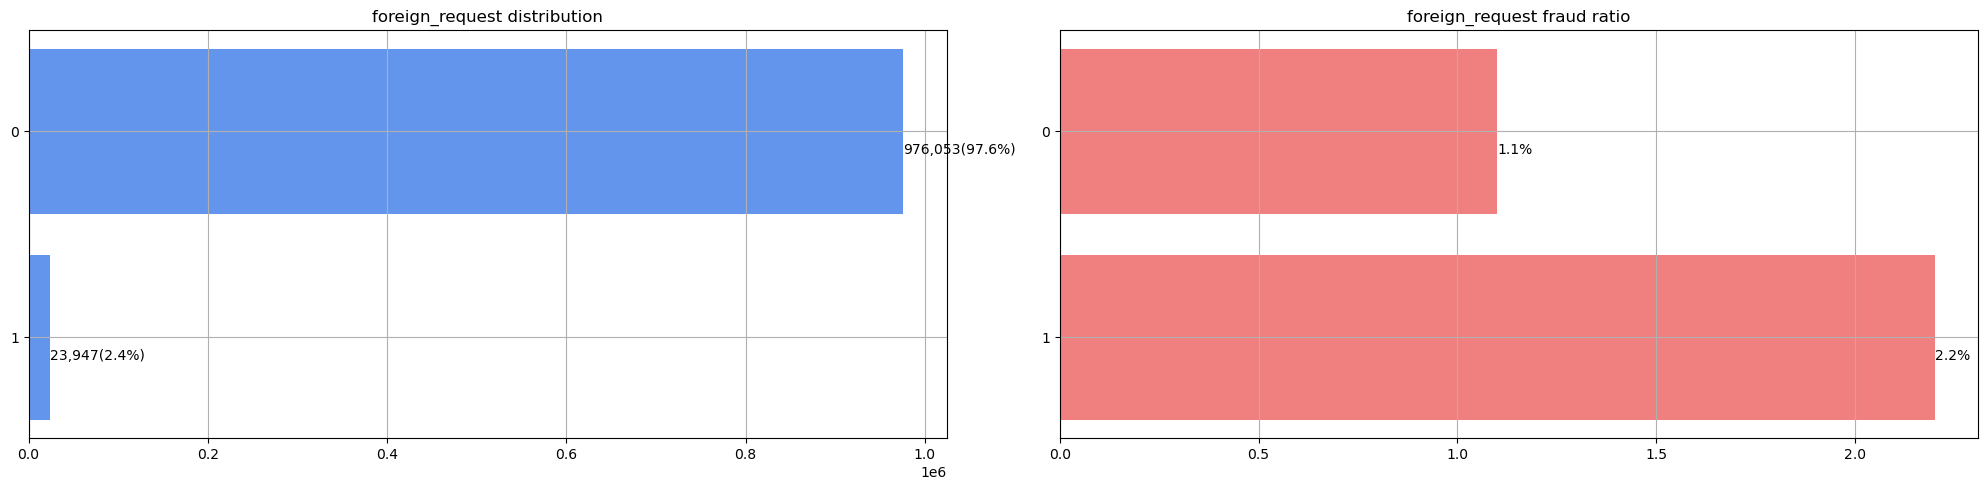

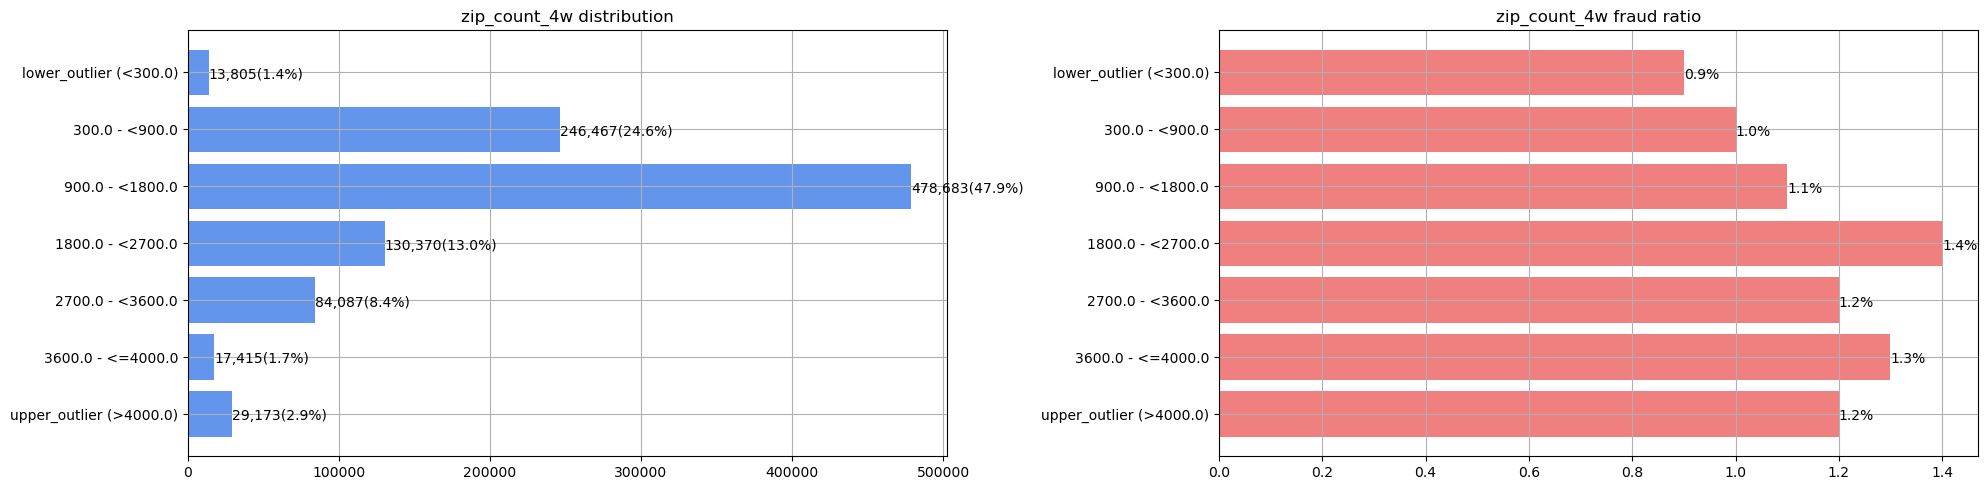

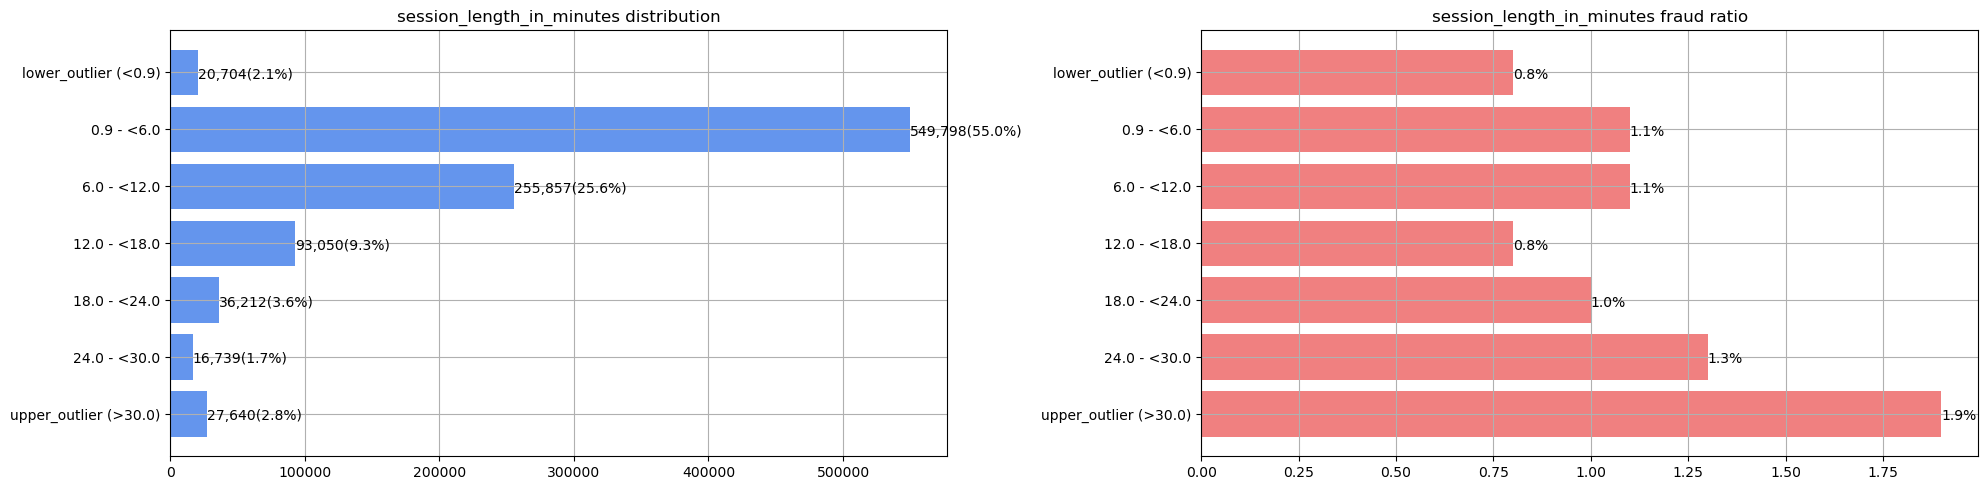

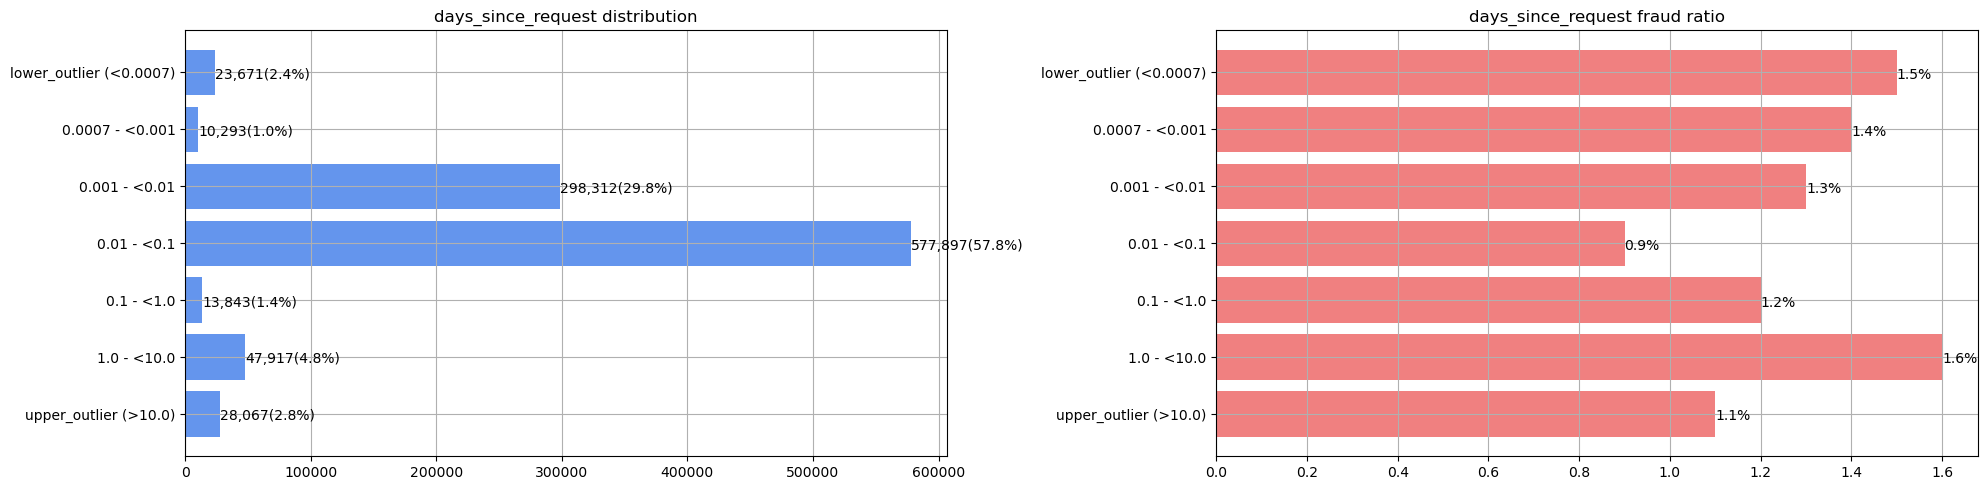

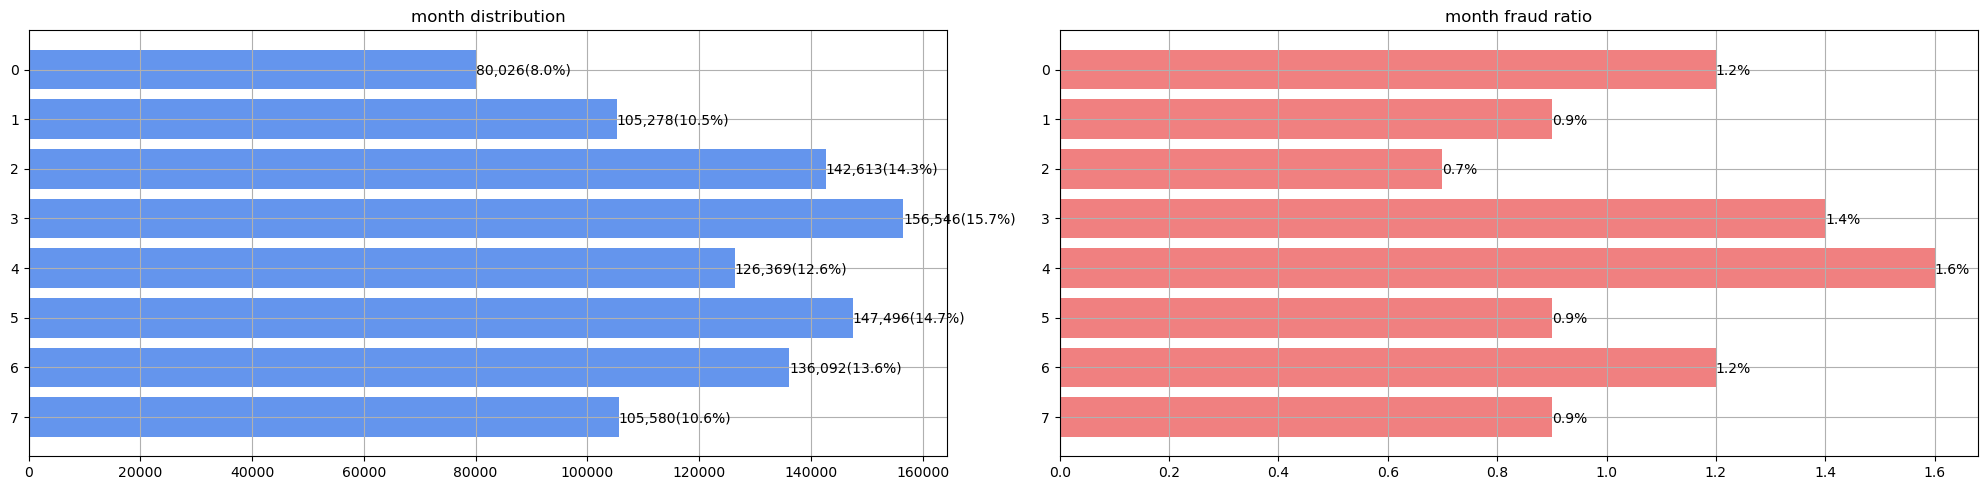

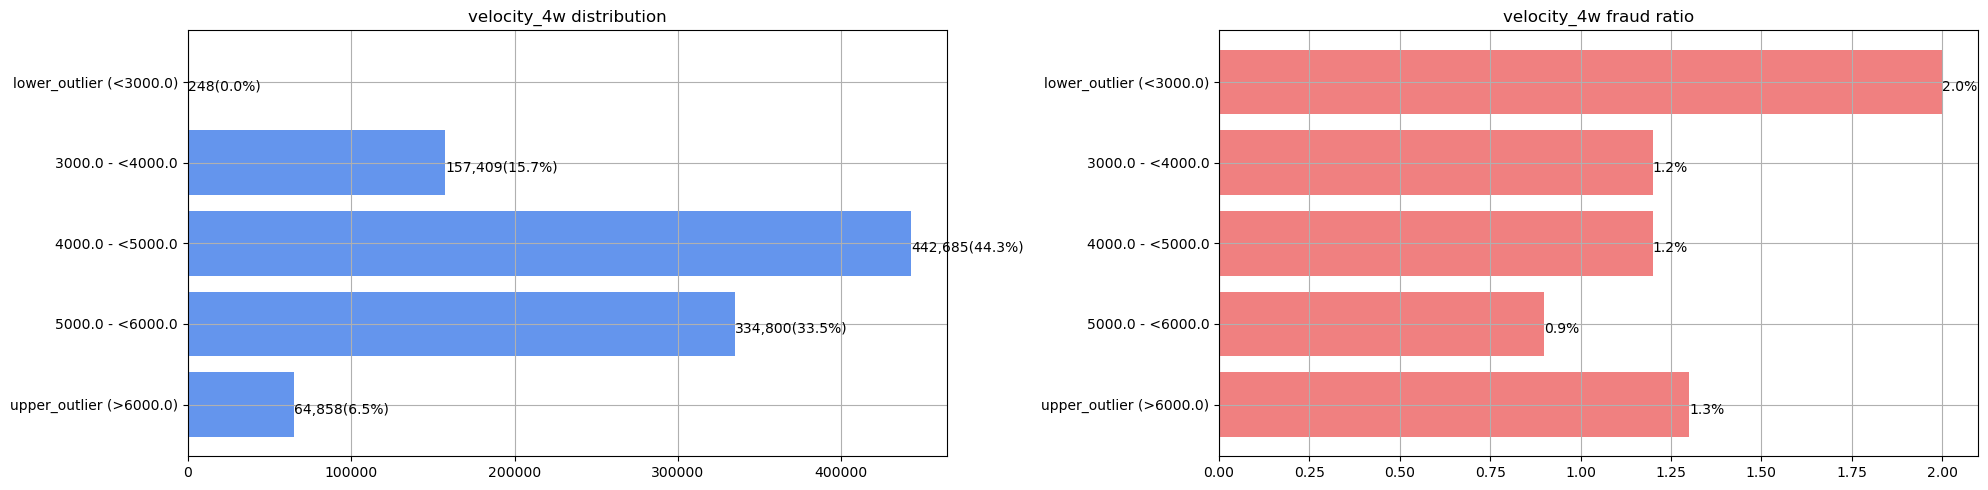

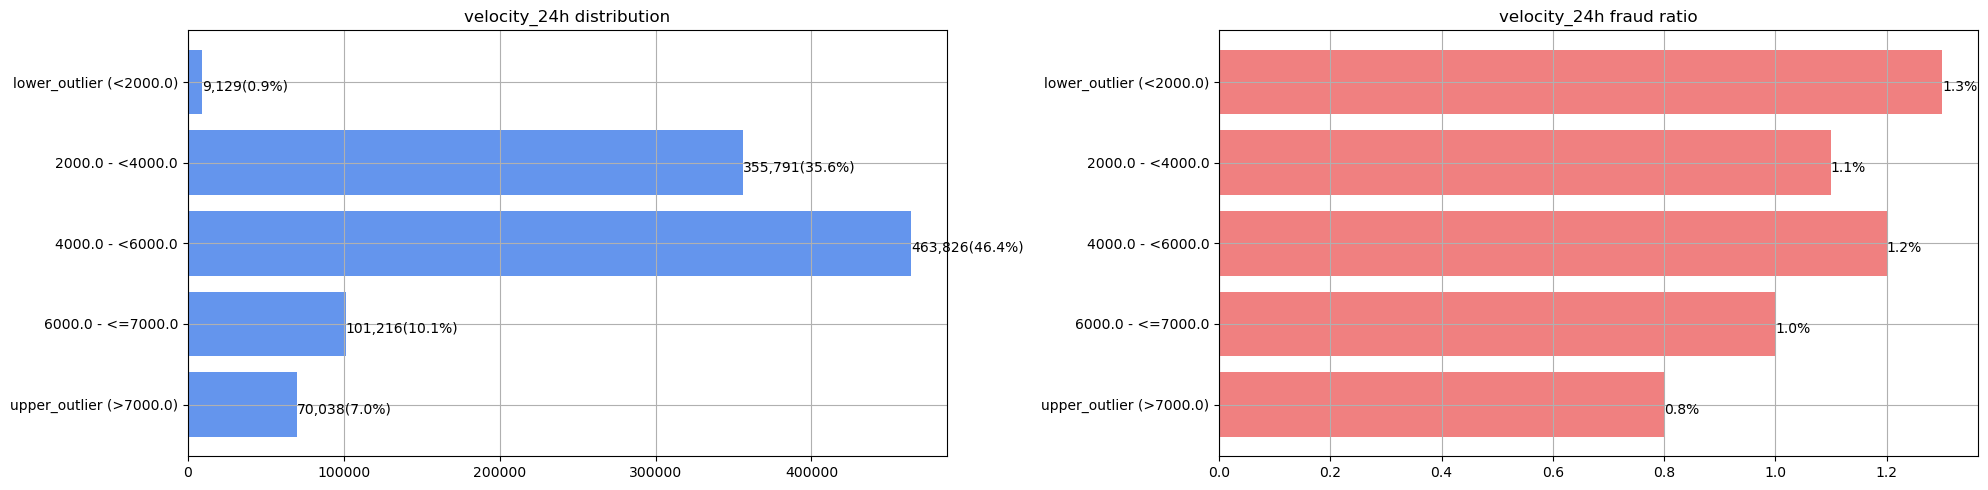

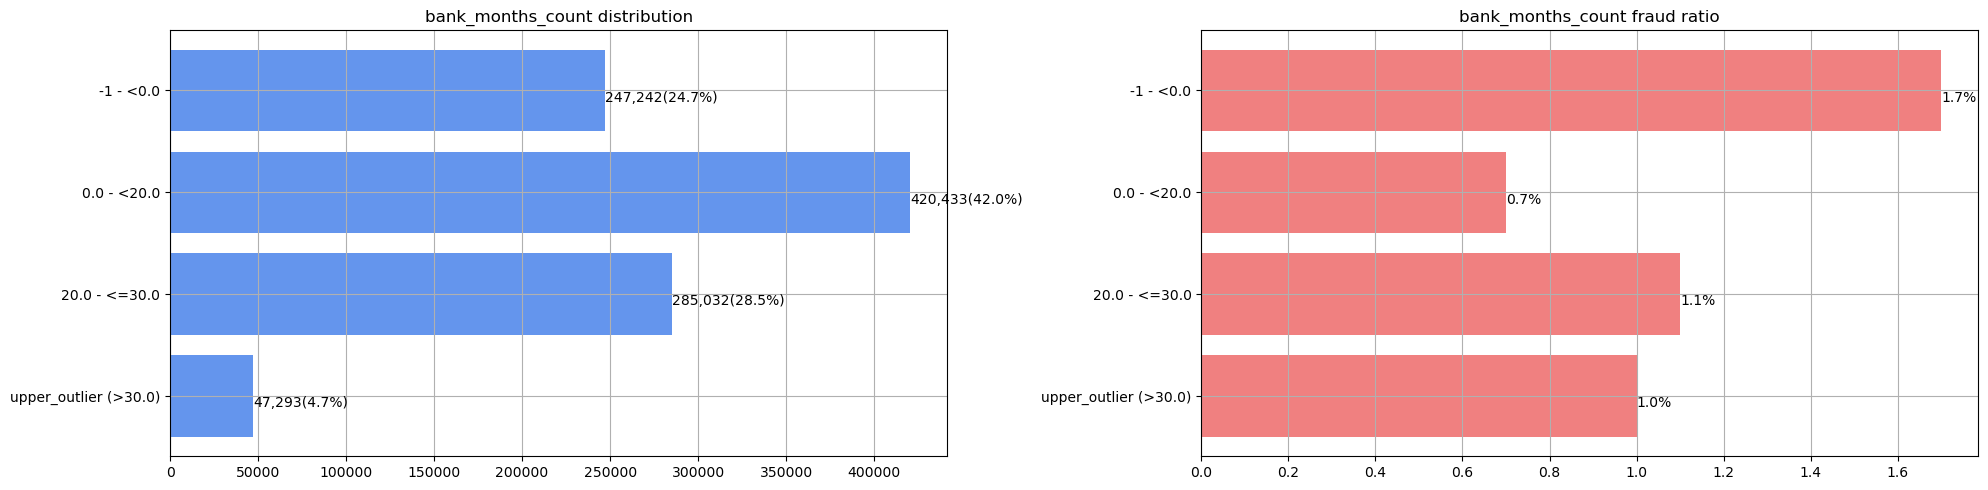

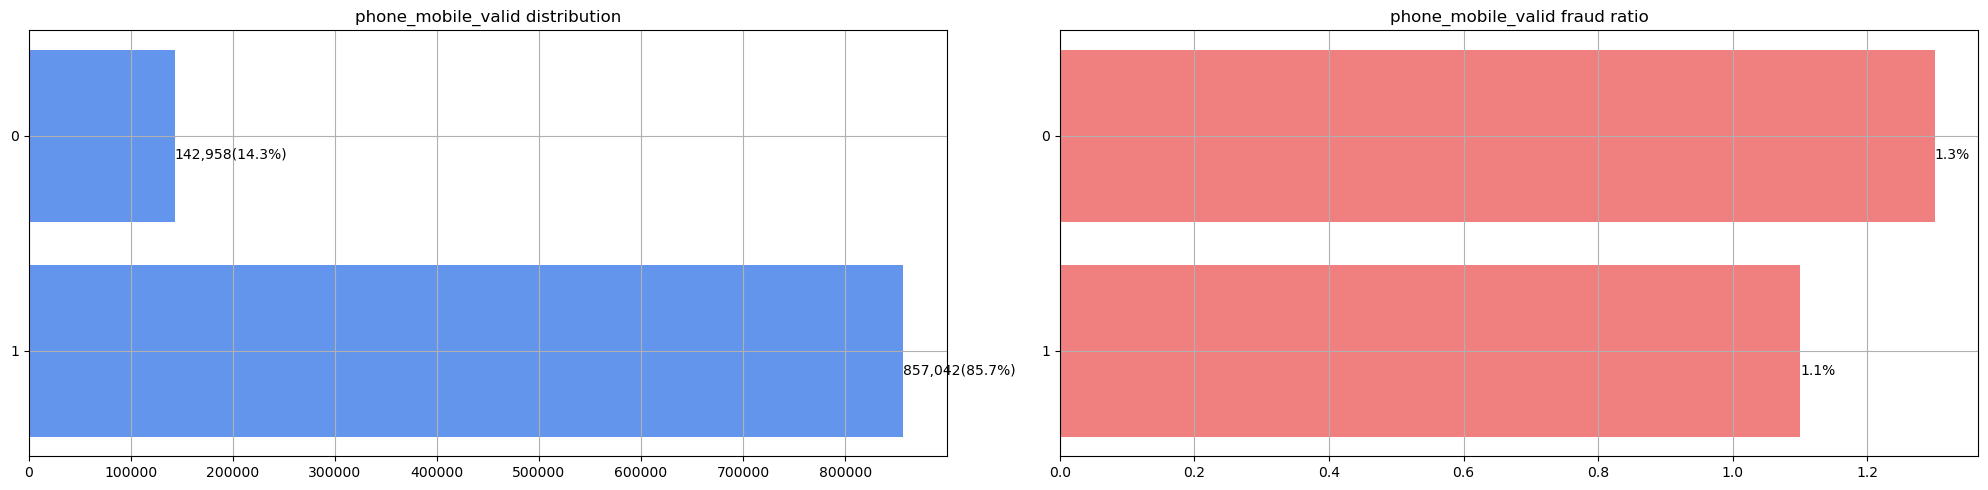

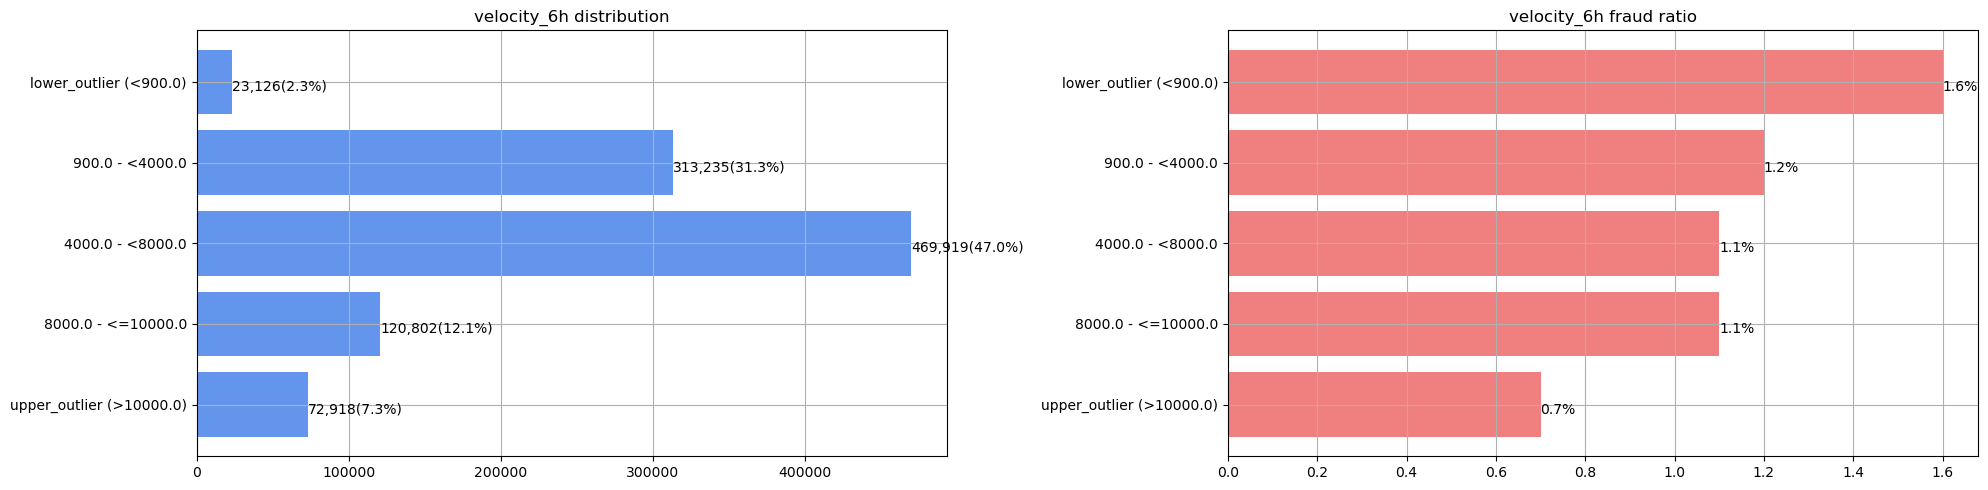

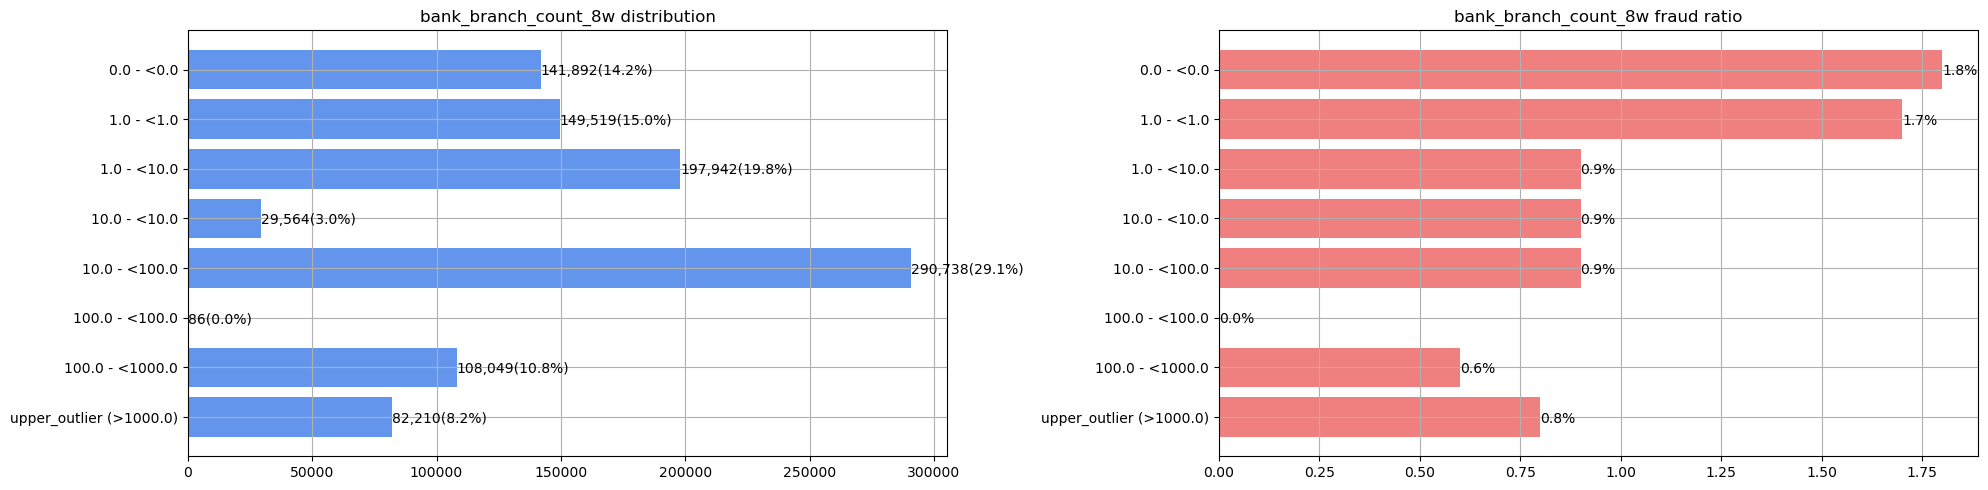

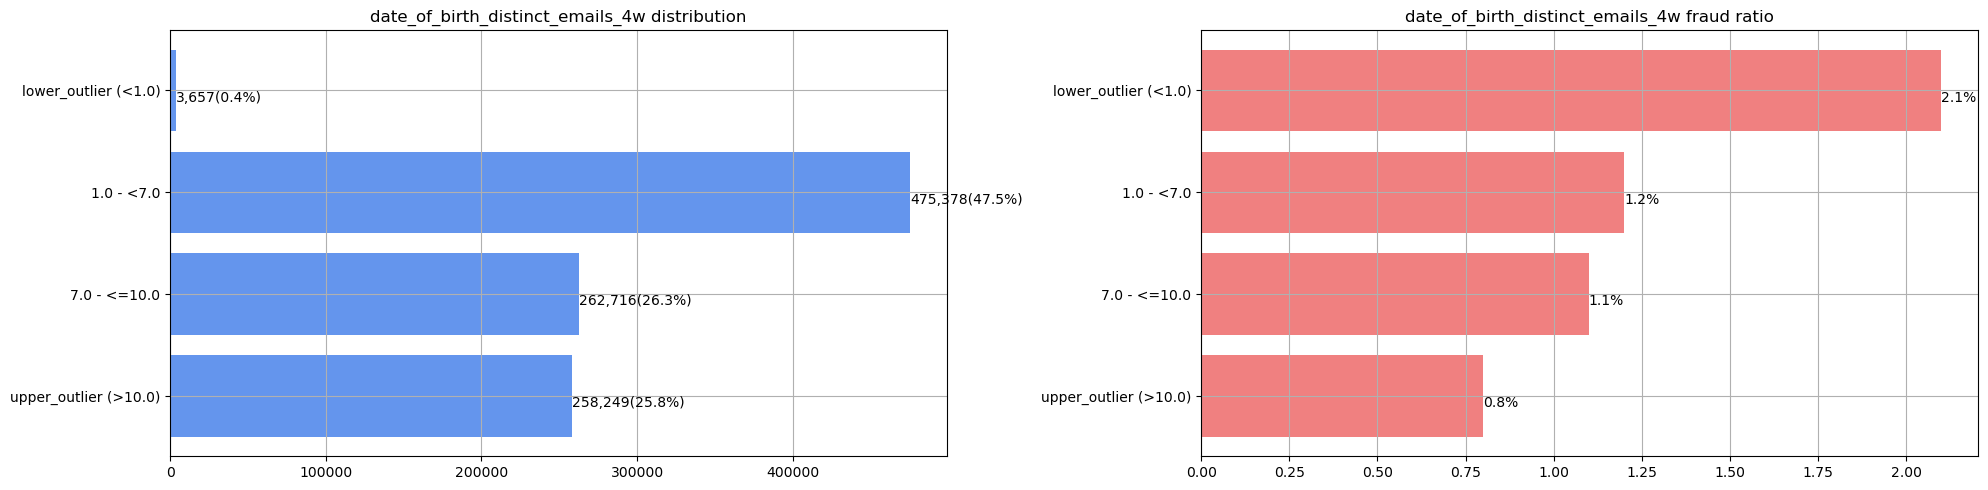

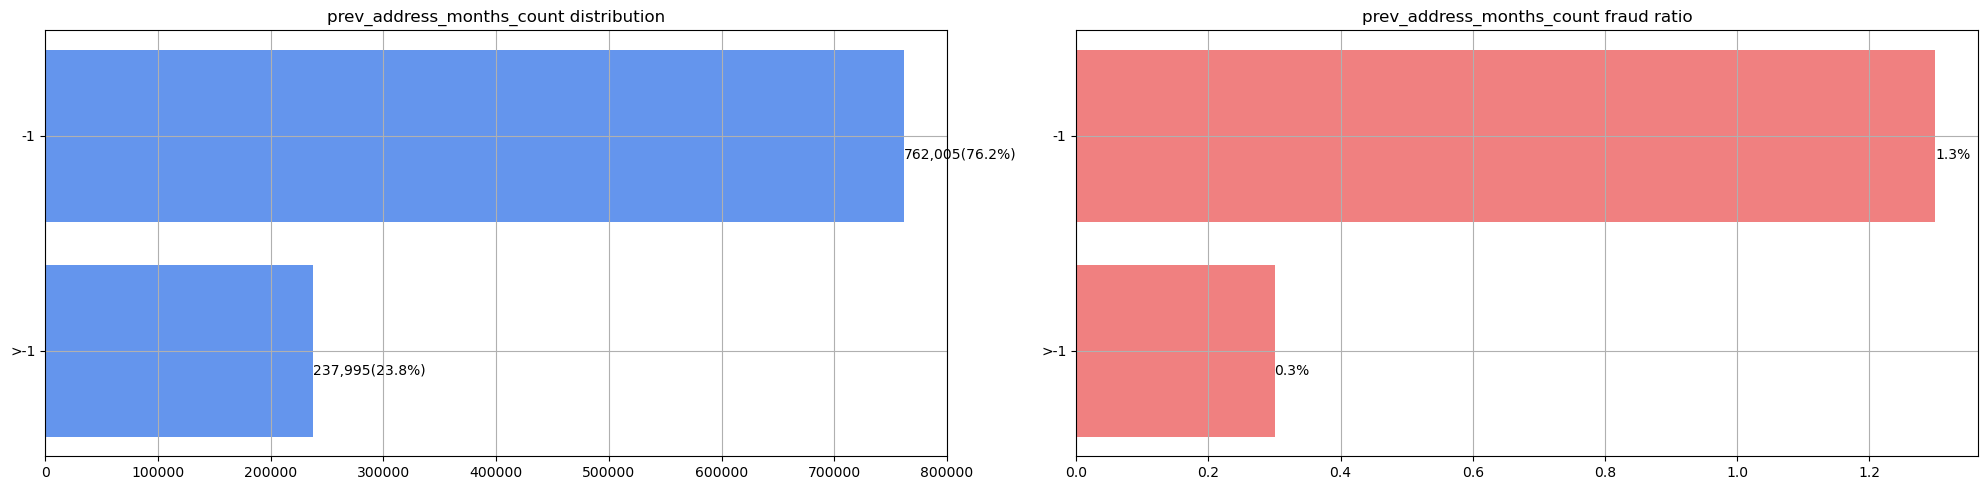

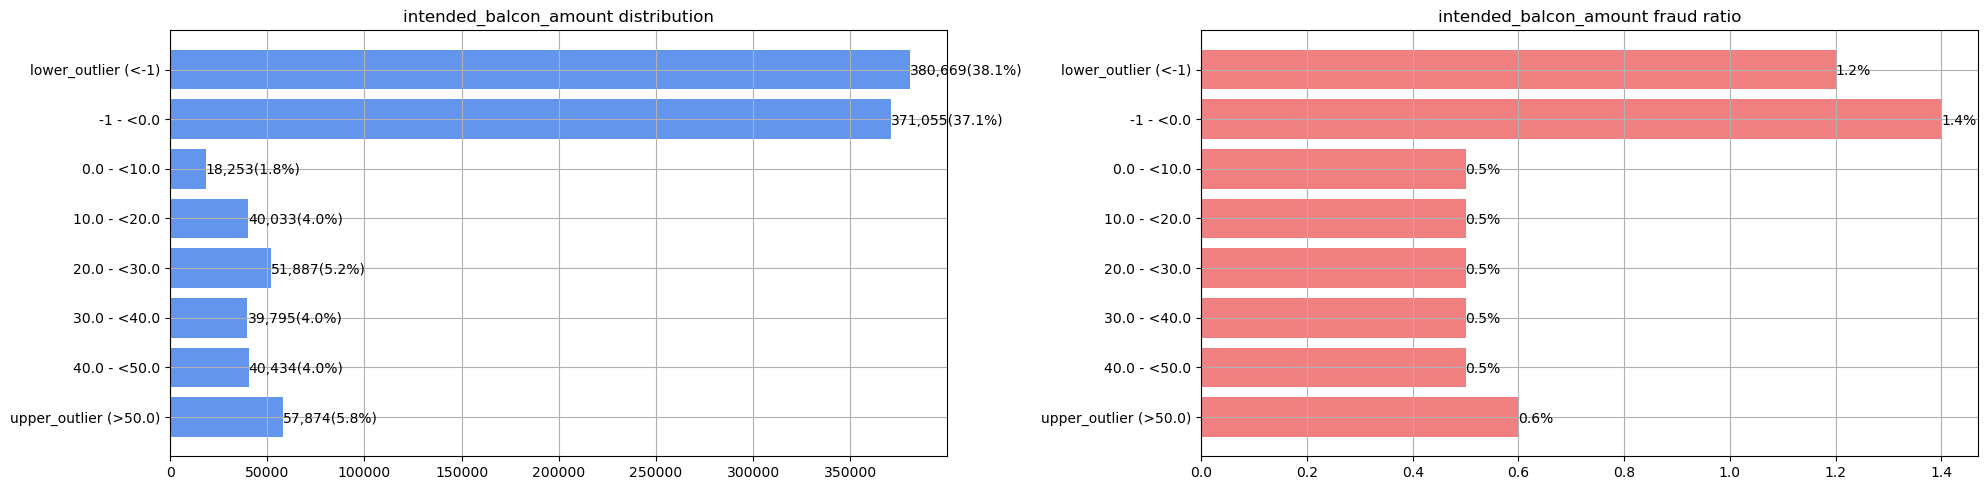

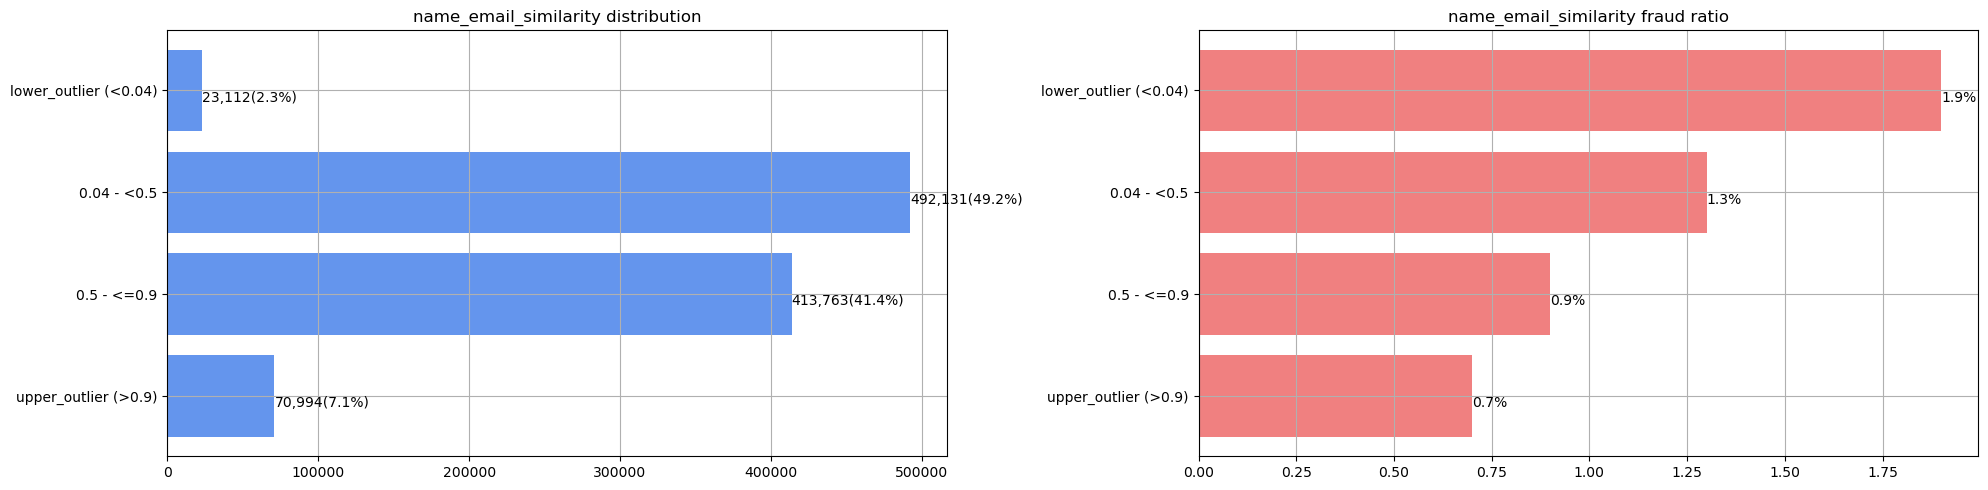

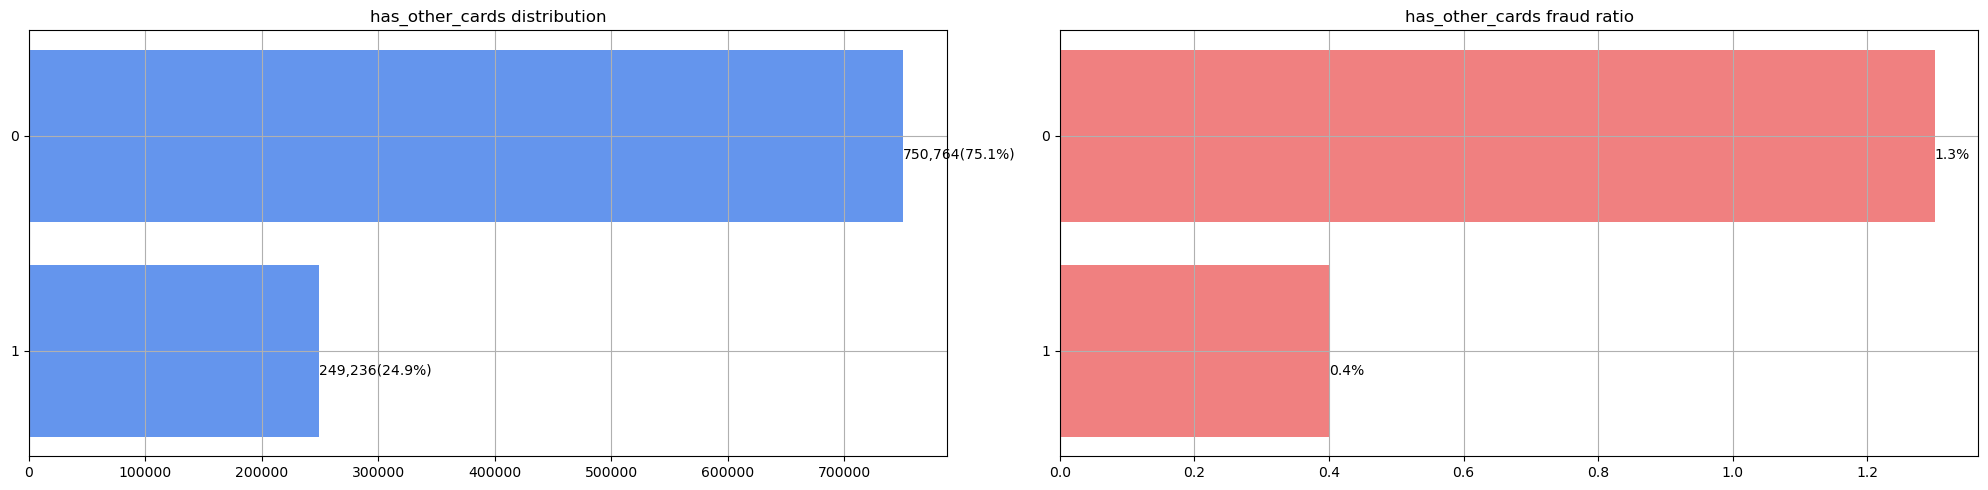

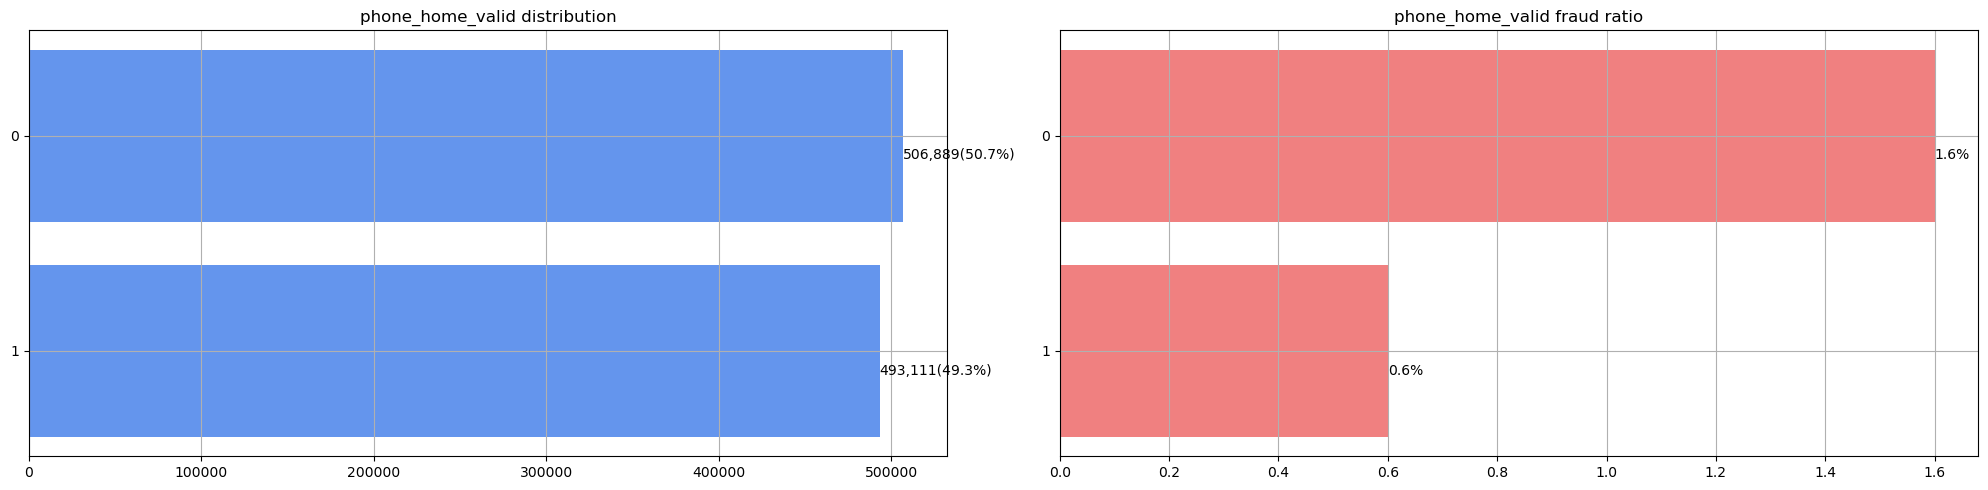

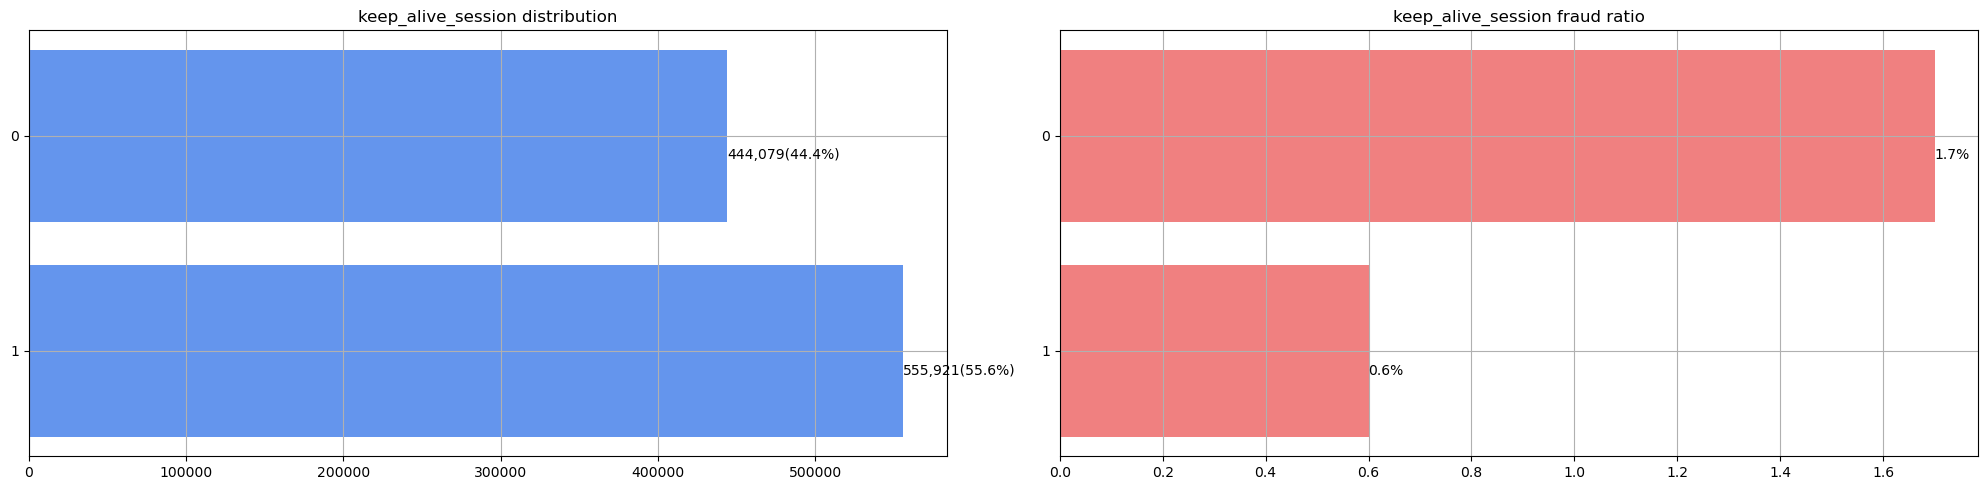

In [10]:
for feat in feat_cols_sorted:
    df_gr = eda.EDAPlot().plot_dist_and_ratio(df, feat, class_col)

In [5]:
importlib.reload(eda)

<module 'eda' from 'd:\\jupyter\\banking\\eda.py'>

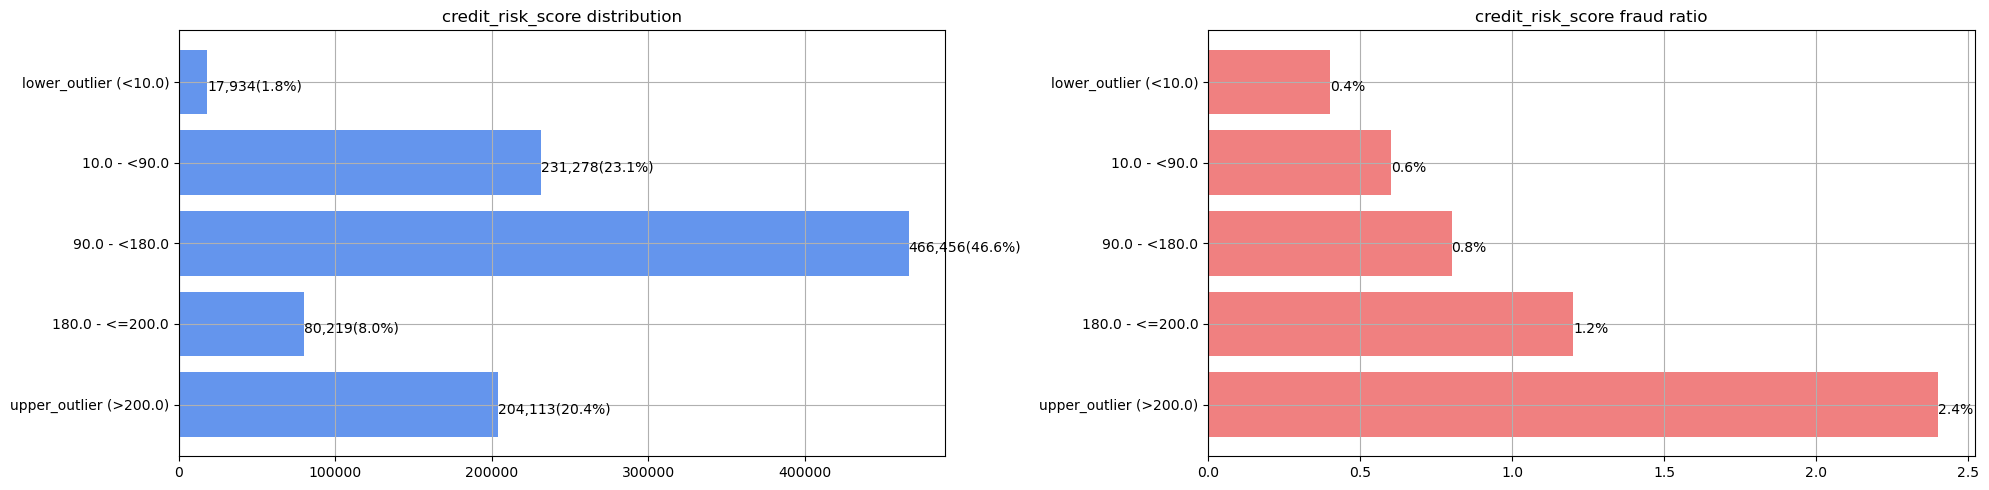

In [6]:
feat = 'credit_risk_score'
df_gr = eda.EDAPlot().plot_dist_and_ratio(df, feat, class_col)


x2: upper outlier not cover last value
credit_risk_score: check lower outlier


model

In [11]:
# preprocessing
def preprocessing(df_X_):
    df_X = df_X_.copy()
    df_X['intended_balcon_amount'] = np.where(df_X['intended_balcon_amount'] < 0, -1, df_X['intended_balcon_amount'])
    df_X['velocity_6h'] = np.where(df_X['velocity_6h'] < 0, -1, df_X['velocity_6h'])
    return df_X

def new_feat(df_X_):
    df_X = df_X_.copy()
    df_X['payment_type_AC'] = np.where(df_X['payment_type'] == 'AC', 1, 0)
    df_X['payment_type_AB_AD'] = np.where(df_X['payment_type'].isin(['AB', 'AD']), 1, 0)
    df_X['employment_status_CC'] = np.where(df_X['employment_status'] == 'CC', 1, 0)
    df_X['employment_status_CA'] = np.where(df_X['employment_status'] == 'CA', 1, 0)
    df_X['employment_status_CG'] = np.where(df_X['employment_status'] == 'CG', 1, 0)
    df_X['housing_status_BA'] = np.where(df_X['housing_status'] == 'BA', 1, 0)
    df_X['device_os_windows'] = np.where(df_X['device_os'] == 'windows', 1, 0)
    df_X['source_internet'] = np.where(df_X['source'] == 'INTERNET', 1, 0)
    df_X = df_X.drop(columns=['payment_type', 'employment_status', 'housing_status', 'device_os', 'source'])
    return df_X


# encoding
def label_encode(X_train_, X_test_):
    X_train = X_train_.copy()
    X_test = X_test_.copy()
    
    for col in str_cols:
        le = LabelEncoder()
        le.fit(X_train[col])
        X_train[col] = le.transform(X_train[col])
        X_test[col] = le.transform(X_test[col])
    return X_train, X_test

def one_hot_encode(X_train_, X_test_):
    encoder = OneHotEncoder(handle_unknown='ignore', max_categories=3, sparse_output=False)
    X_train_encoded = encoder.fit_transform(X_train_[str_cols])
    X_test_encoded = encoder.transform(X_test_[str_cols])

    X_train = X_train_[[c for c in feat_cols if c not in str_cols]].copy().reset_index(drop=True) \
        .join(pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out()))
    X_test = X_test_[[c for c in feat_cols if c not in str_cols]].copy().reset_index(drop=True) \
        .join(pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out()))

    return X_train, X_test


# evaluation
def tpr_from_fpr(y_test, y_predict, fpr_threshold=0.05):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict)
    
    idx = np.argmin(np.abs(fpr - fpr_threshold))
    threshold = thresholds[idx]

    tpr_threshold = tpr[idx]
    return tpr_threshold

def auc_(y_test, y_predict):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict)
    auc_ = metrics.auc(fpr, tpr)
    return auc_

def eval(model, X, y, type='train'):
    y_predict = model.predict_proba(X)[:,1]
    print('tpr_' + type + ' =', tpr_from_fpr(y, y_predict, fpr_threshold=0.05))
    print('auc_' + type + ' =', auc_(y, y_predict))
    print()

In [12]:
df_train_test = df[df['month'] < 6]
df_infer = df[df['month'] >= 6]

df_train, df_test = train_test_split(df_train_test, test_size=0.2, random_state=42, stratify=df_train_test[class_col])
df_train = preprocessing(df_train)
df_test = preprocessing(df_test)
df_infer = preprocessing(df_infer)

X_train_ = df_train[feat_cols]
y_train = df_train[class_col]

X_test_ = df_test[feat_cols]
y_test = df_test[class_col]

X_infer_ = df_infer[feat_cols]
y_infer = df_infer[class_col]

In [13]:
# label encode, lgbm

X_train, X_test = label_encode(X_train_, X_test_)

clf = LGBMClassifier(random_state=42)
clf.fit(X_train, y_train)

y_predict = clf.predict_proba(X_test)[:,1]
print('tpr =', tpr_from_fpr(y_test, y_predict, fpr_threshold=0.05))
print('auc =', auc_(y_test, y_predict))

tpr = 0.736873508353222
auc = 0.9523184162953743


In [36]:
# one hot encode, lgbm

X_train, X_test = one_hot_encode(X_train_, X_test_)

clf = LGBMClassifier(random_state=42)
clf.fit(X_train, y_train)

y_predict = clf.predict_proba(X_test)[:,1]
print('tpr =', tpr_from_fpr(y_test, y_predict, fpr_threshold=0.05))
print('auc =', auc_(y_test, y_predict))

tpr = 0.5077062556663645
auc = 0.8845696683558362


In [37]:
# new feat, lgbm

X_train = new_feat(X_train_)
X_test = new_feat(X_test_)

clf = LGBMClassifier(random_state=42)
clf.fit(X_train, y_train)

y_predict = clf.predict_proba(X_test)[:,1]
print('tpr =', tpr_from_fpr(y_test, y_predict, fpr_threshold=0.05))
print('auc =', auc_(y_test, y_predict))

tpr = 0.5194922937443336
auc = 0.8911965571367322


In [73]:
# preprocessing, new feat, lgbm

X_train = new_feat(X_train_)
X_test = new_feat(X_test_)

clf = LGBMClassifier(random_state=42)
clf.fit(X_train, y_train)

y_predict = clf.predict_proba(X_test)[:,1]
print('tpr =', tpr_from_fpr(y_test, y_predict, fpr_threshold=0.05))
print('auc =', auc_(y_test, y_predict))

tpr = 0.5196319018404908
auc = 0.8895781697887302


In [83]:
# preprocessing, new feat, lgbm

X_train = new_feat(X_train_)
X_test = new_feat(X_test_)
X_infer = new_feat(X_infer_)

clf = LGBMClassifier(random_state=42)
clf.fit(X_train, y_train)

eval(clf, X_train, y_train, 'train')
eval(clf, X_test, y_test, 'test')
eval(clf, X_infer, y_infer, 'infer')


tpr_train = 0.7054132801717528
auc_train = 0.9360051027609955

tpr_test = 0.5196319018404908
auc_test = 0.8895781697887302

tpr_infer = 0.5104239054899236
auc_infer = 0.8856798257700458



In [53]:
# preprocessing, new feat, lgbm

X_train = new_feat(X_train_)
X_test = new_feat(X_test_)

clf = LGBMClassifier(random_state=42)
clf.fit(X_train, y_train)

y_predict = clf.predict_proba(X_test)[:,1]
print('tpr =', tpr_from_fpr(y_test, y_predict, fpr_threshold=0.05))
print('auc =', auc_(y_test, y_predict))

tpr = 0.5235720761559384
auc = 0.8914375791636326


In [54]:
df_feat_imp = pd.DataFrame({
    'feat': X_train.columns,
    'imp': clf.feature_importances_
}).sort_values(by='imp', ascending=False)
df_feat_imp

,feat,imp
3,current_address_months_count,227
13,credit_risk_score,213
5,days_since_request,199
1,name_email_similarity,192
10,velocity_4w,189
9,velocity_24h,168
21,session_length_in_minutes,159
11,bank_branch_count_8w,158
7,zip_count_4w,142
12,date_of_birth_distinct_emails_4w,119


In [55]:
# preprocessing, new feat, rf

X_train = new_feat(X_train_)
X_test = new_feat(X_test_)

clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
clf.fit(X_train, y_train)

y_predict = clf.predict_proba(X_test)[:,1]
print('tpr =', tpr_from_fpr(y_test, y_predict, fpr_threshold=0.05))
print('auc =', auc_(y_test, y_predict))

tpr = 0.4845874886672711
auc = 0.8722540469061876


In [56]:
df_feat_imp = pd.DataFrame({
    'feat': X_train.columns,
    'imp': clf.feature_importances_
}).sort_values(by='imp', ascending=False)
df_feat_imp

,feat,imp
1,name_email_similarity,0.078891
13,credit_risk_score,0.071528
10,velocity_4w,0.066746
5,days_since_request,0.065534
21,session_length_in_minutes,0.063766
8,velocity_6h,0.060248
7,zip_count_4w,0.059820
9,velocity_24h,0.059178
3,current_address_months_count,0.055962
12,date_of_birth_distinct_emails_4w,0.043540


resampling

In [14]:
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [15]:
# preprocessing, new feat, sampling, lgbm

X_train = new_feat(X_train_)
X_test = new_feat(X_test_)
X_infer = new_feat(X_infer_)

print(y_train.value_counts())

# nm = NearMiss(sampling_strategy=0.1, n_jobs=-1)
nm = RandomUnderSampler(sampling_strategy=0.2)
X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)

print(y_train_nm.value_counts())

# sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(X_train_nm, y_train_nm)

# print(y_res.value_counts())

clf = LGBMClassifier(random_state=42)
# clf.fit(X_res, y_res)
clf.fit(X_train_nm, y_train_nm)

eval(clf, X_train, y_train, 'train')
eval(clf, X_test, y_test, 'test')
eval(clf, X_infer, y_infer, 'infer')


0    599960
1      6702
Name: fraud_bool, dtype: int64
0    33510
1     6702
Name: fraud_bool, dtype: int64
tpr_train = 0.846911369740376
auc_train = 0.9747716208535059

tpr_test = 0.75
auc_test = 0.9526214357011231

tpr_infer = 0.7503770739064857
auc_infer = 0.9531613471196425



In [16]:
df_feat_imp = pd.DataFrame({
    'feat': X_train.columns,
    'imp': clf.feature_importances_
}).sort_values(by='imp')
df_feat_imp.sort_values(by='imp', ascending=False)

,feat,imp
24,x1,282
25,x2,270
3,current_address_months_count,201
4,customer_age,190
13,credit_risk_score,163
1,name_email_similarity,155
21,session_length_in_minutes,147
5,days_since_request,146
10,velocity_4w,144
7,zip_count_4w,115


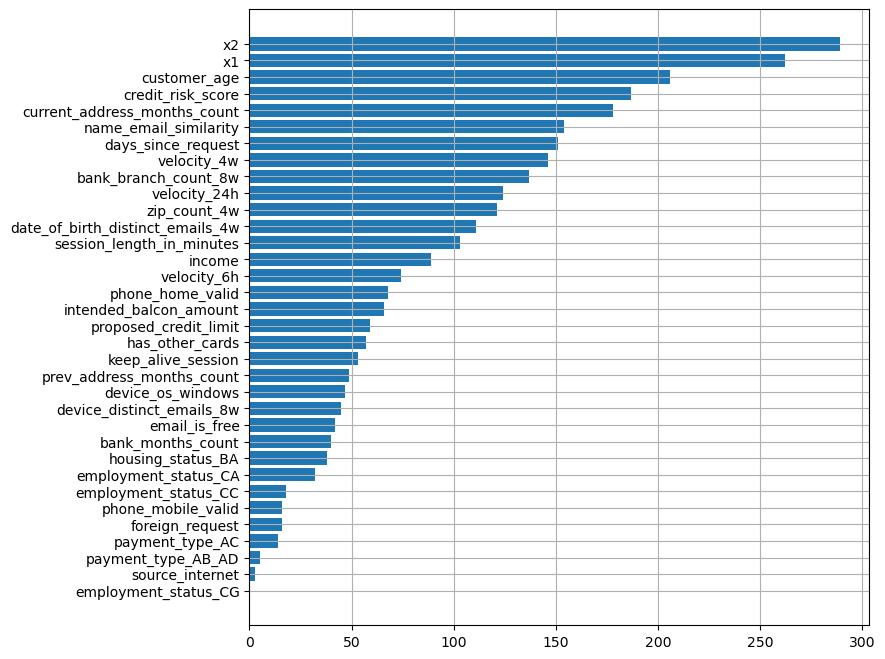

In [29]:
plt.figure(figsize=(8, 8))
plt.barh(df_feat_imp['feat'], df_feat_imp['imp'])
plt.grid()
plt.show()

feature selection

In [135]:
from sklearn.feature_selection import RFE, RFECV, SequentialFeatureSelector

In [131]:
# preprocessing, new feat, sampling, lgbm, rfe

X_train = new_feat(X_train_)
X_test = new_feat(X_test_)

nm = RandomUnderSampler(sampling_strategy=0.2)
X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)

estimator = LGBMClassifier(random_state=42)
selector = RFE(estimator, n_features_to_select=25, step=1)
selector = selector.fit(X_train_nm, y_train_nm)

feat_cols_model = X_train_nm.columns[selector.support_].tolist()

X_train_feat_selection = X_train_nm[feat_cols_model]

clf = LGBMClassifier(random_state=42)
clf.fit(X_train_feat_selection, y_train_nm)

eval(clf, X_train[feat_cols_model], y_train, 'train')
eval(clf, X_test[feat_cols_model], y_test, 'test')
eval(clf, X_infer[feat_cols_model], y_infer, 'infer')


tpr_train = 0.6031283545468487
auc_train = 0.923430155240196

tpr_test = 0.5049079754601227
auc_test = 0.8826015680334134

tpr_infer = 0.5034746351633078
auc_infer = 0.8753611462040862



In [139]:
# preprocessing, new feat, sampling, lgbm, rfe

X_train = new_feat(X_train_)
X_test = new_feat(X_test_)

nm = RandomUnderSampler(sampling_strategy=0.2)
X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)

estimator = LGBMClassifier(random_state=42)
sfs = SequentialFeatureSelector(estimator , n_features_to_select=10)
sfs.fit(X_train_nm, y_train_nm)

feat_cols_model = X_train_nm.columns[sfs.support_].tolist()

X_train_feat_selection = X_train_nm[feat_cols_model]

clf = LGBMClassifier(random_state=42)
clf.fit(X_train_feat_selection, y_train_nm)

eval(clf, X_train[feat_cols_model], y_train, 'train')
eval(clf, X_test[feat_cols_model], y_test, 'test')
eval(clf, X_infer[feat_cols_model], y_infer, 'infer')


tpr_train = 0.5183254102131575
auc_train = 0.8898165049223529

tpr_test = 0.48098159509202454
auc_test = 0.8633389190839619

tpr_infer = 0.45378735232800554
auc_infer = 0.8588105071022822



In [140]:
# preprocessing, new feat, sampling, lgbm, rfe

X_train = new_feat(X_train_)
X_test = new_feat(X_test_)

nm = RandomUnderSampler(sampling_strategy=0.2)
X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)

estimator = LGBMClassifier(random_state=42)
sfs = SequentialFeatureSelector(estimator , n_features_to_select=20)
sfs.fit(X_train_nm, y_train_nm)

feat_cols_model = X_train_nm.columns[sfs.support_].tolist()

X_train_feat_selection = X_train_nm[feat_cols_model]

clf = LGBMClassifier(random_state=42)
clf.fit(X_train_feat_selection, y_train_nm)

eval(clf, X_train[feat_cols_model], y_train, 'train')
eval(clf, X_test[feat_cols_model], y_test, 'test')
eval(clf, X_infer[feat_cols_model], y_infer, 'infer')


tpr_train = 0.591166998926545
auc_train = 0.9195095743483672

tpr_test = 0.5245398773006135
auc_test = 0.8821433945769878

tpr_infer = 0.5038220986796387
auc_infer = 0.8816621668061617



In [141]:
# preprocessing, new feat, sampling, lgbm, rfe

X_train = new_feat(X_train_)
X_test = new_feat(X_test_)

nm = RandomUnderSampler(sampling_strategy=0.2)
X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)

estimator = LGBMClassifier(random_state=42)
sfs = SequentialFeatureSelector(estimator , n_features_to_select=30)
sfs.fit(X_train_nm, y_train_nm)

feat_cols_model = X_train_nm.columns[sfs.support_].tolist()

X_train_feat_selection = X_train_nm[feat_cols_model]

clf = LGBMClassifier(random_state=42)
clf.fit(X_train_feat_selection, y_train_nm)

eval(clf, X_train[feat_cols_model], y_train, 'train')
eval(clf, X_test[feat_cols_model], y_test, 'test')
eval(clf, X_infer[feat_cols_model], y_infer, 'infer')


tpr_train = 0.6170832694372029
auc_train = 0.9265202687036204

tpr_test = 0.5411042944785276
auc_test = 0.8899005823714208

tpr_infer = 0.5225851285615011
auc_infer = 0.8876996120598968



interpretable

In [17]:
from sklearn.inspection import PartialDependenceDisplay
import shap
# from alibi.explainers import ALE, plot_ale
from PyALE import ale

In [18]:
def interpretable_plot(model, X, feat_cols, interpretable_algo='pdp'):
    ncols = 3
    nrows = int(np.ceil(len(feat_cols)/ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(20,20))
    for i in range(nrows):
        for j in range(ncols):
            if i*ncols + j < len(feat_cols):
                feat_col = feat_cols[i*ncols + j]
                if interpretable_algo=='pdp':
                    PartialDependenceDisplay.from_estimator(model, X, features=[feat_col], ax=axs[i,j])
                elif interpretable_algo=='ale':
                    ale_eff = ale(X=X, model=model, feature=[feat_col], grid_size=50, include_CI=False)
                elif interpretable_algo=='shap':
                    explainer = shap.Explainer(model)
                    shap_values = explainer(X)
                    shap.plots.bar(shap_values)
                else:
                    raise ValueError('interpretable_algo must be pdp, ale or shap')
                axs[i,j].grid(True)
    plt.show()

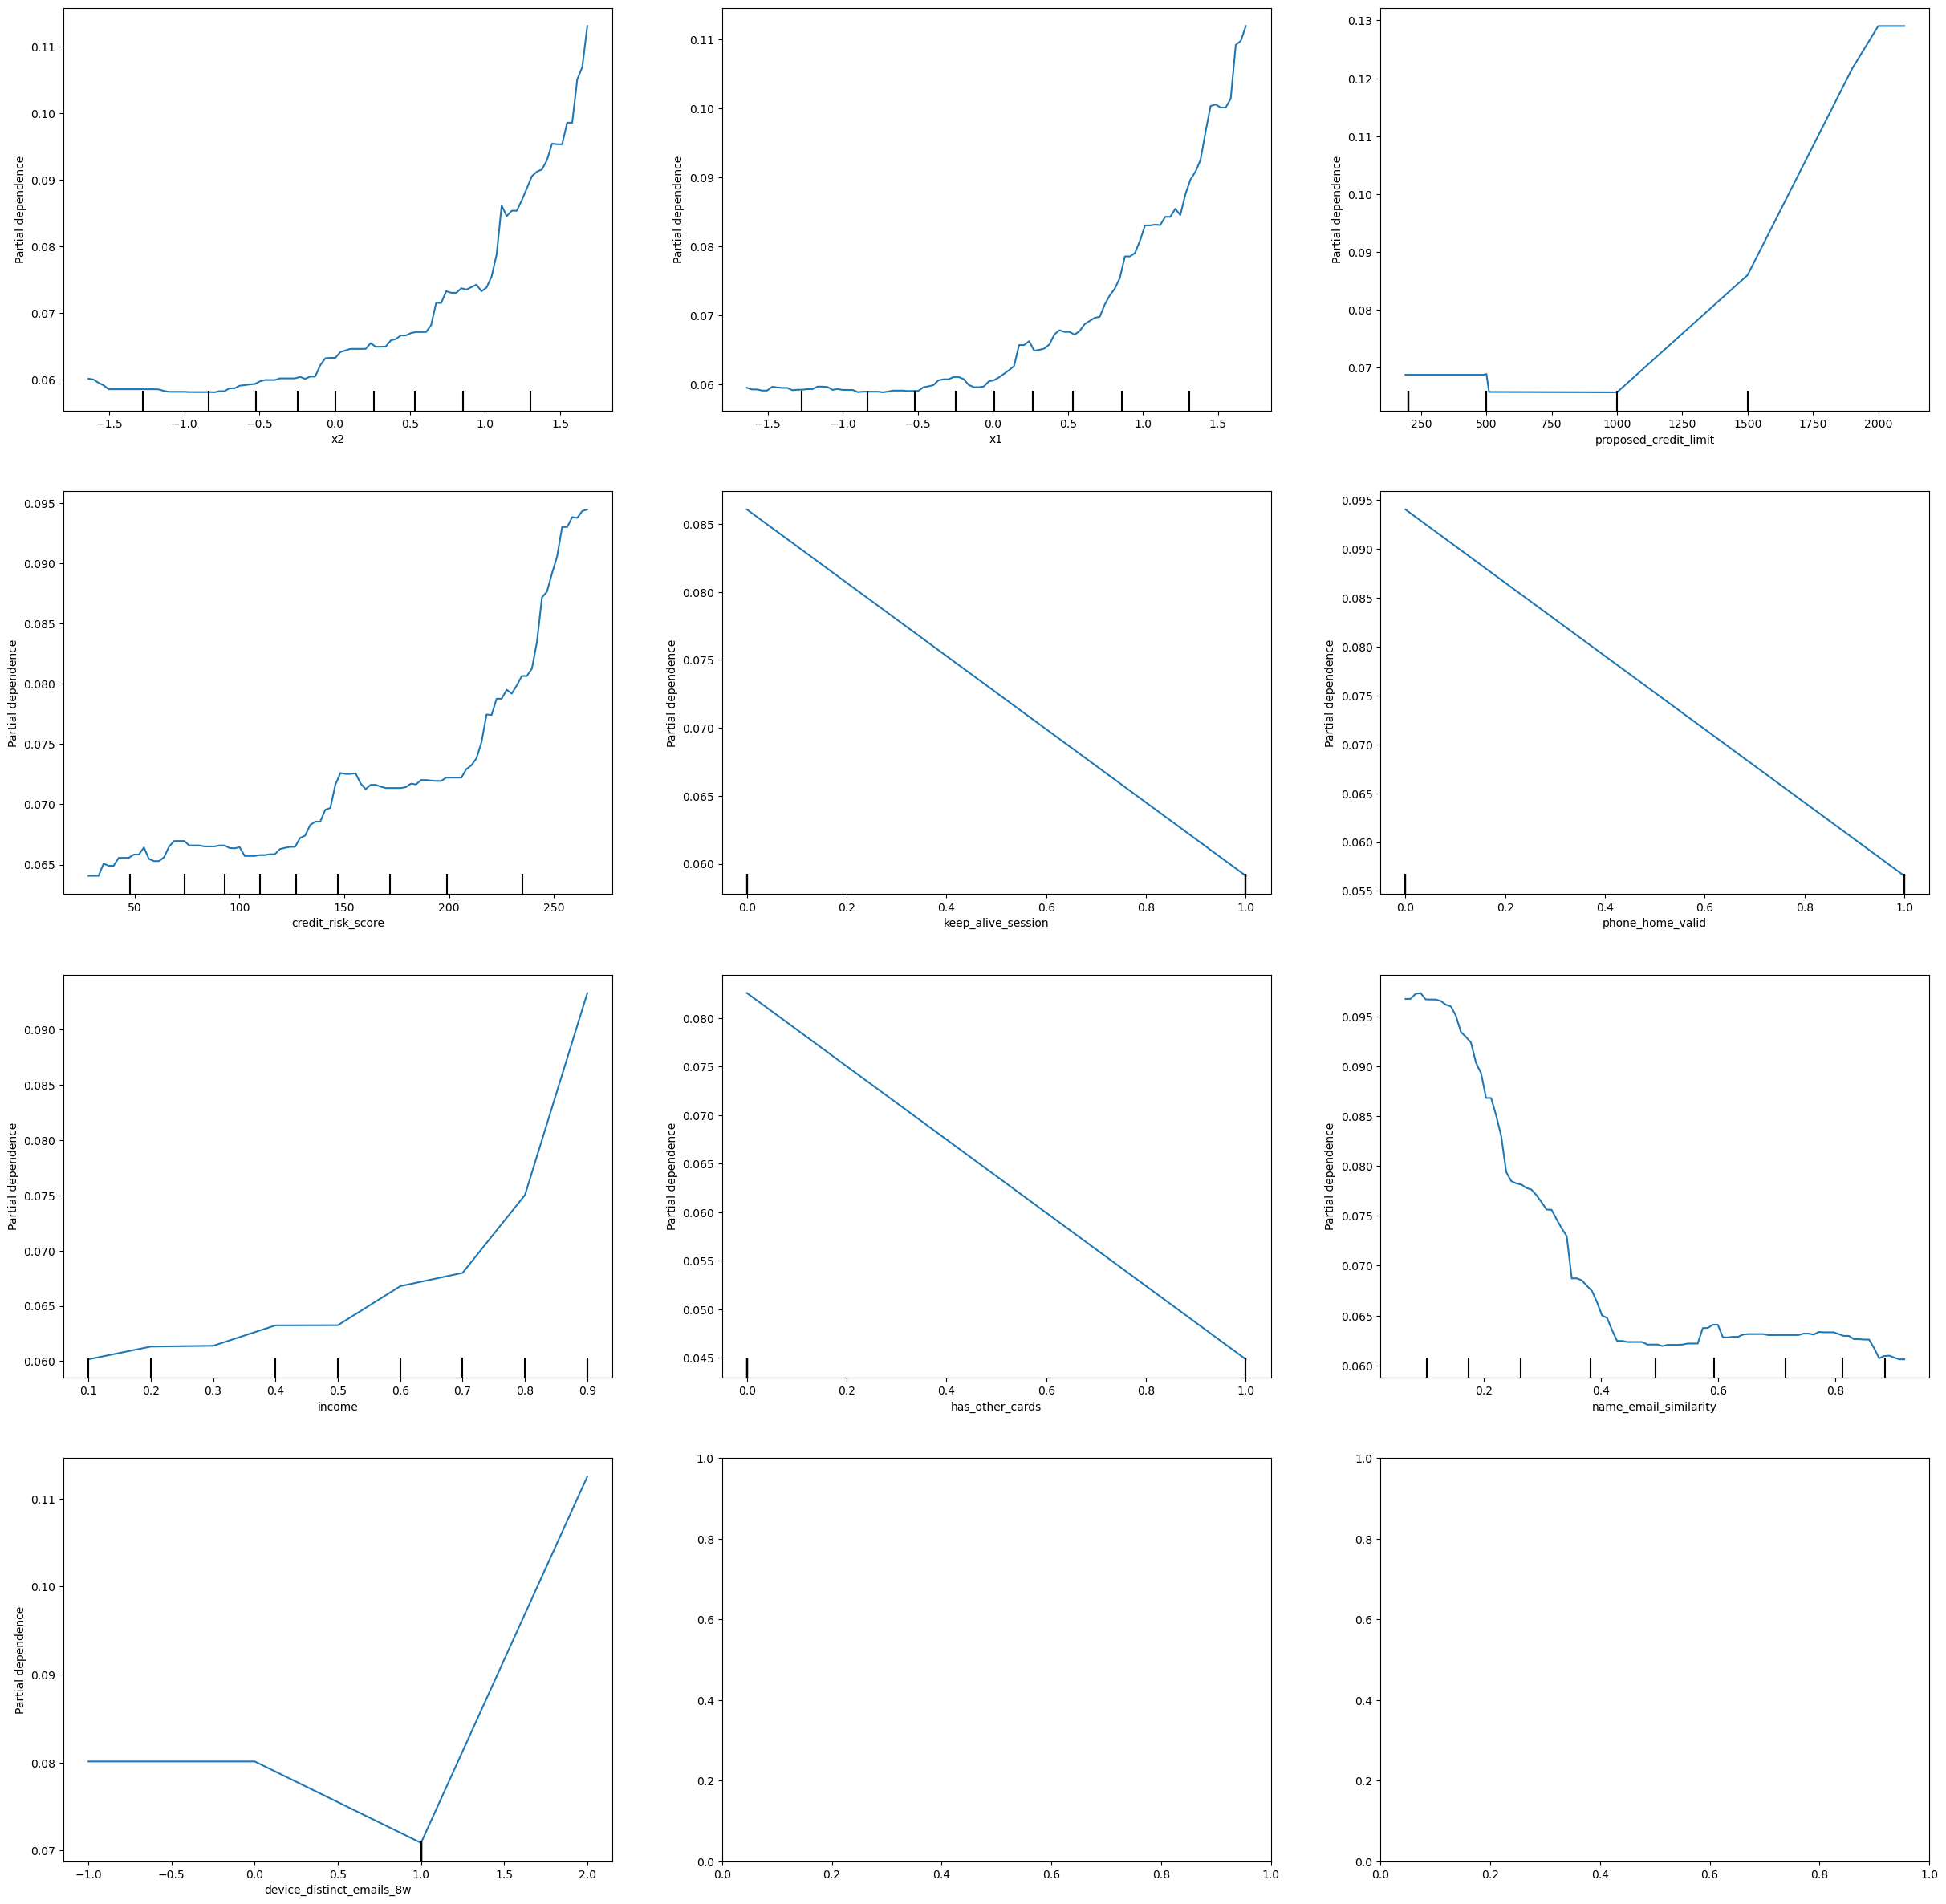

In [32]:
interpretable_plot(clf, X_train, feat_cols_sorted_2[:10], interpretable_algo='pdp')

In [28]:
X_train_sample = X_train.sample(frac=0.2)

In [30]:
help(shap.plots.bar)

Help on function bar in module shap.plots._bar:

bar(shap_values, max_display=10, order=shap.Explanation.abs, clustering=None, clustering_cutoff=0.5, merge_cohorts=False, show_data='auto', show=True)
    Create a bar plot of a set of SHAP values.
    
    If a single sample is passed, then we plot the SHAP values as a bar chart. If an
    :class:`.Explanation` with many samples is passed, then we plot the mean absolute
    value for each feature column as a bar chart.
    
    
    Parameters
    ----------
    shap_values : shap.Explanation or shap.Cohorts or dictionary of shap.Explanation objects
        A single row of a SHAP :class:`.Explanation` object (i.e. ``shap_values[0]``) or
        a multi-row Explanation object that we want to summarize.
    
    max_display : int
        How many top features to include in the bar plot (default is 10).
    
    show : bool
        Whether ``matplotlib.pyplot.show()`` is called before returning.
        Setting this to ``False`` allows the

In [36]:
explainer = shap.Explainer(clf)
shap_values = explainer(X_train_nm)
shap.plots.bar(shap_values)

IndexError: list index out of range

IndexError: list index out of range

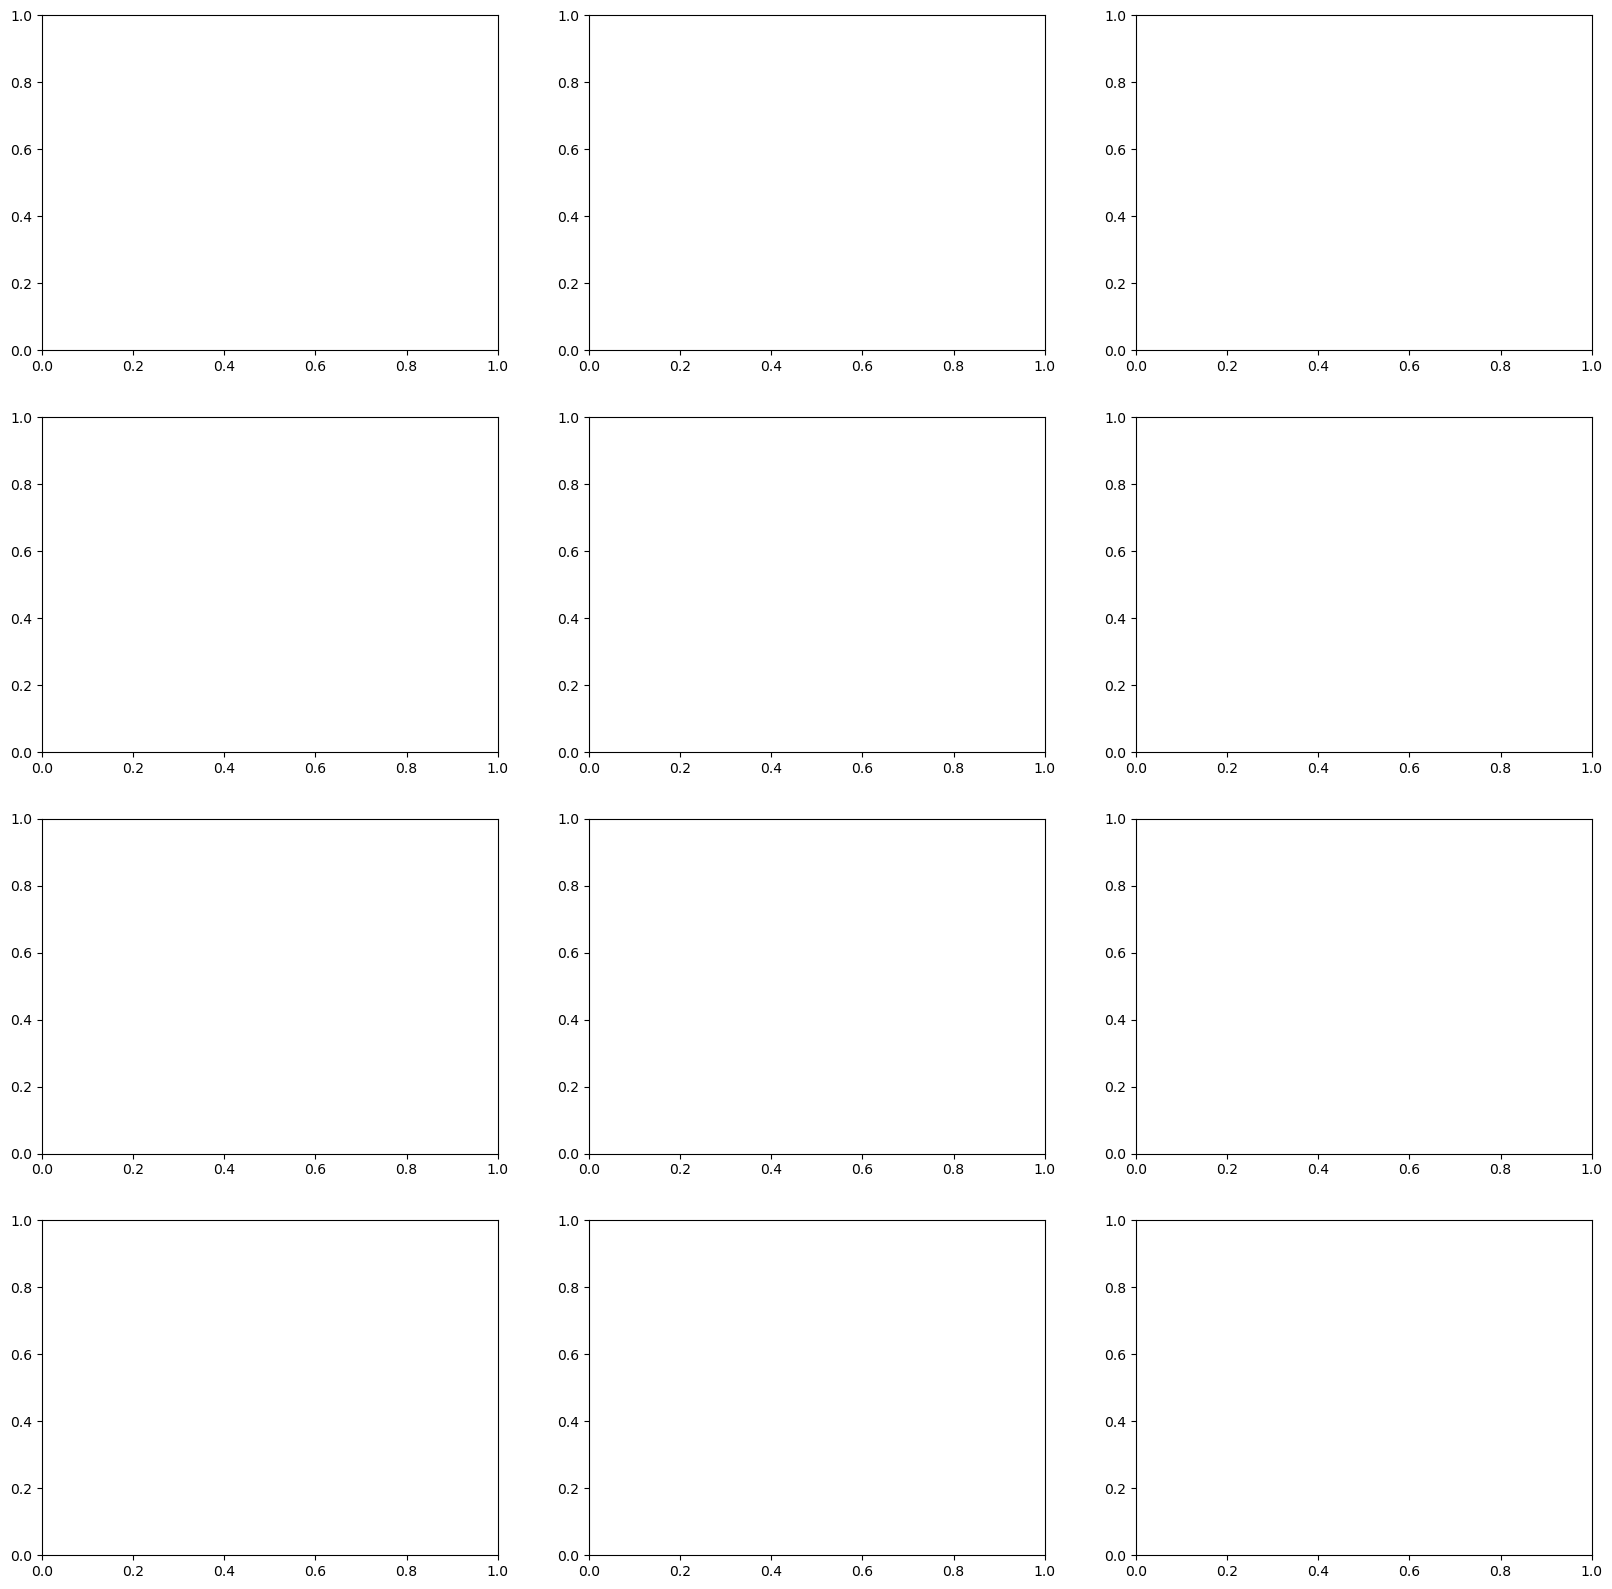

In [19]:
interpretable_plot(clf, X_train, feat_cols_sorted_2[:10], interpretable_algo='shap')

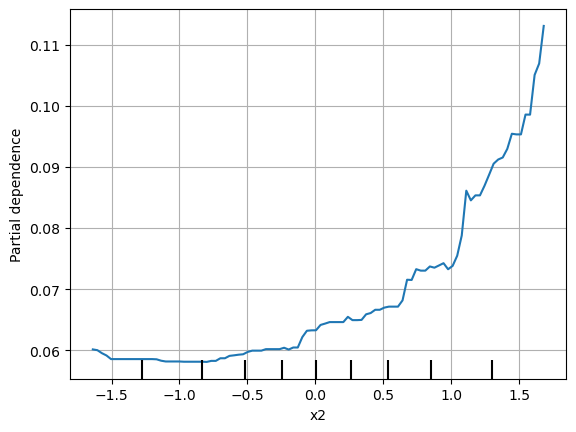

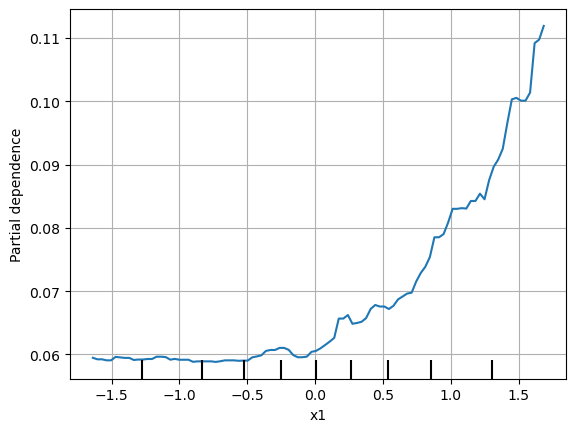

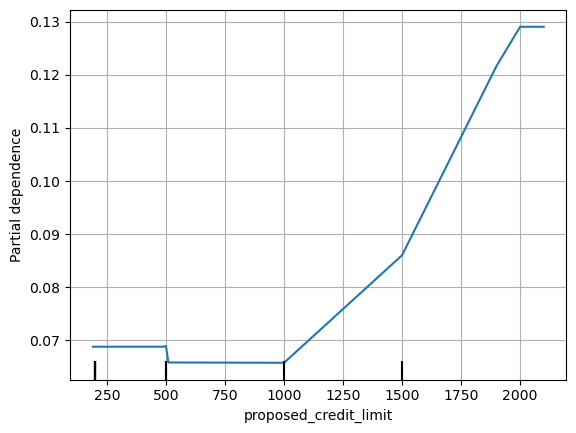

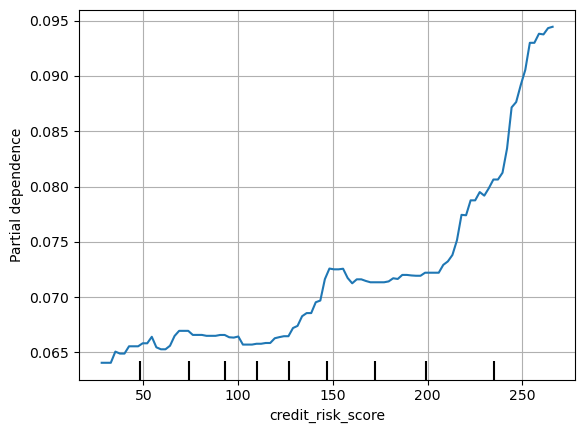

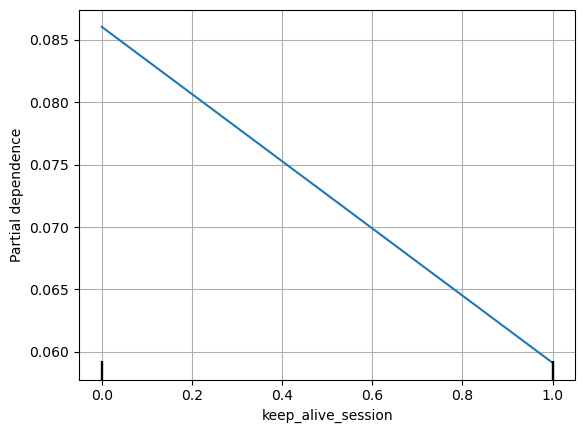

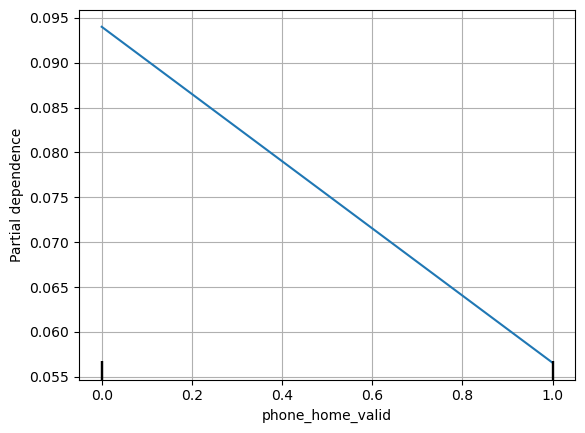

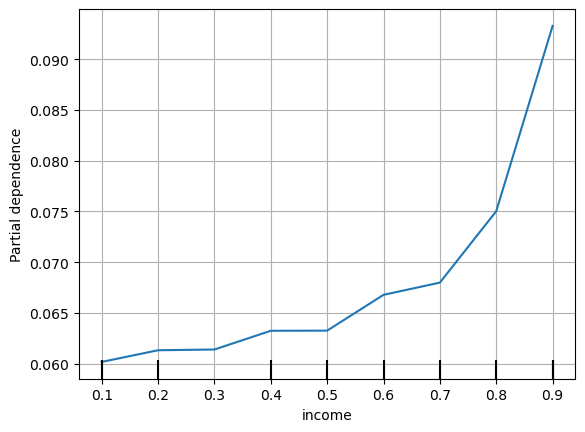

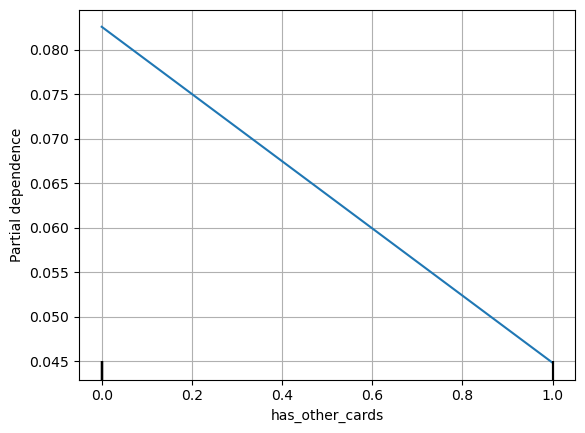

KeyboardInterrupt: 

In [27]:
for i in feat_cols_sorted_2[:10]:
  PartialDependenceDisplay.from_estimator(clf, X_train, features=[i])
  plt.grid()
  plt.show()

In [ ]:
for i in feat_cols_sorted_2[:10]:
  PartialDependenceDisplay.from_estimator(clf, X_train, features=[i], kind='individual')
  plt.grid()
  plt.show()